# Analysis of single-plex TMT experiments

## Comet/PAW pipeline


### Phil Wilmarth, OHSU PSR Core, February 2019

## Overview and objectives

Most ways that isobaric labeling data are analyzed hinder statistical testing and data visualization. This notebook will analyze data from (**Ref-1**) to demonstrate a two-condition (3 controls and 4 treatments) comparison done with 10-plex TMT reagents using the SPS MS3 method (**Ref-2**) on a Thermo Fusion instrument. The notebook will show how to:

- load in a complicated results table and extract the data
- normalize the data and visualize the result
- compare the two conditions using edgeR
- visualize the differential expression candidates
- export the statistical test results in a useful format

## Experiment background and PAW data processing

The KUR1502 data were mouse bone marrow cell cultures where the "media" samples are controls (one of the 4 did not label) and there are leukemia exosome-dosed cells (4 "exosome" samples). 10-plex TMT was used on a Thermo Fusion using the SPS MS3 method. The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) (**Ref-3**) is our in-house processing using the Comet search engine (**Ref-4**). The pipeline converts the RAW files into text files using MSConvert from the Proteowizard toolkit (**Ref-5**).

Data from the MS2 scans are extracted for the Comet searches and the reporter peak heights are extracted from the MS3 scans. The pipeline uses the target/decoy method to make score histograms and determine score filtering thresholds. Accurate mass is used to create conditional score histograms where target/decoy delta mass histograms are used to set the accurate mass windows. Basic parsimony principles are used for protein inference and 2 peptides per protein were required. An additional protein grouping step was used to combine nearly identical peptide sets (often these are housekeeping genes).

> **1.** Huan, J., Hornick, N.I., Goloviznina, N.A., Kamimae-Lanning, A.N., David, L.L., Wilmarth, P.A., Mori, T., Chevillet, J.R., Narla, A., Roberts Jr, C.T. and Loriaux, M.M., 2015. Coordinate regulation of residual bone marrow function by paracrine trafficking of AML exosomes. Leukemia, 29(12), p.2285.

> **2.** McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158.

> **3.** Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> **4.** Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

> **5.** Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918

---

## Load libraries and read in the data file

In [1]:
# load libraries
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 

# read the grouped protein summary file
paw_raw <- read_tsv("grouped_protein_summary_TMT_8_sorted.txt", skip = 4,
                    n_max = 5427, guess_max = 5427)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following objects are masked from ‘package:psych’:

    alpha, rescale

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Parsed with column specification:
cols(
  .default = col_number(),
  ProtGroup = col_double(),
  Counter = col_double(),
  Accession = col_character(),
  I

## Extract the relevant data table

In [2]:
# extract protein accession column and TMT data
# need to exclude any rows with an entry in "Filter" column
# there are also 4 unused channels (of 11-plex slots)
paw_tmt <- paw_raw %>% 
  filter(., is.na(Filter)) %>%
  select(Accession, starts_with("TotInt_")) %>%
  select(-contains("127N"), -contains("128N"), -contains("130N"), -contains("131C"))

# separate accessions from the data
accession <- paw_tmt$Accession
paw_tmt <- paw_tmt %>% select(-Accession)

# rename the columns and gather the conditions
colnames(paw_tmt) <- c("Media_2.1", "Exo_2.1", "Exo_2.2", "Media_2.2",
                      "Exo_3.1", "Exo_3.2", "Media_3.2")
paw_tmt <- paw_tmt %>% select(contains("Media"), contains("Exo"))

head(paw_tmt)
nrow(paw_tmt)

Media_2.1,Media_2.2,Media_3.2,Exo_2.1,Exo_2.2,Exo_3.1,Exo_3.2
3933357,4407161,3673067,3365868,2877318,4087298,4900769
5776706,7291692,5960994,6059613,4975721,7275906,8452274
1014940,1257965,1085345,960414,817656,1651860,1998265
6870884,8431112,6883385,5565945,4276295,7595261,8567091
5581931,7025343,6028481,5919861,4716778,7657665,8385431
5784291,7072911,5227963,5569973,4762455,6382760,6863332


[1] 4976

## Check PAW zero replacement

Zero replacement is always a controversial topic. How it applies to TMT data is also not simple. How I approached this problem in the PAW pipeline is described [here](https://pwilmart.github.io/blog/2018/12/12/TMT-zero-replacement). There is another complication at the moment. With high resolution instruments, reporter ions can be extracted for all 11 m/z windows whether or not an 11-plex kit was used. This can be handy to see what the true background levels are like in known unused channels. The script that adds reporter ion intensities to the peptide and protein reports, does a trimmed average test to zero out reporter ions near the lower detection limits. This dataset had a lot of PSMs rejected despite a low minimum trimmed intensity of cutoff of 500.

|Total PSMs|Rejected PSMs|% Rejected|
|---|---|---|
|86,781|28,052|32%|

The first-generation Fusion instruments are not as sensitive as the Lumos models. The extra round of isolation in the SPS MS3 method reduces signal levels. Sample loads and separations need to be appropriately scaled up for Fusion instruments.

## Check zero replacement situation

With so many rejected PSMs, there might be significant numbers of proteins that had zero reporter ion sums. Those were replaced by a value of 150 in the `add_TMT_intensites.py` script. Checking for zeros after aggregating to the final protein values, where many PSMs might be combined, helps reduce missing data, but we should never take things for granted. After we have dropped the 4 unused channels (of the 11 TMT slots), we can see how many proteins had different numbers of zero replacements. 

In [3]:
counts <- 1:nrow(paw_tmt) # create vector of appropriate length
for(i in 1:nrow(paw_tmt)){
    # TRUE will be coerced to 1 for the summing
    counts[i] <- sum(paw_tmt[i, ] == 150)
}
table(counts) # create the summary

counts
   0    1    2    3    4 
4908   51    8    8    1 

### We do not have excessive missing data

The vast majority of the protein have no missing values or just one. There are only 17 proteins that more than one missing value. We can keep an eye out for those in the final results sheet after the analysis. We really only need to worry about them if they get flagged as significant differential expression (DE) candidates.

---

## What do the unnormalized data distributions look like?

We will use box plots, a common way to summarize distributions, and distribution density plots to visualize the Log base 10 of the intensities. The 3 media samples are in red color and the 4 exosome-dosed samples are in blue color.

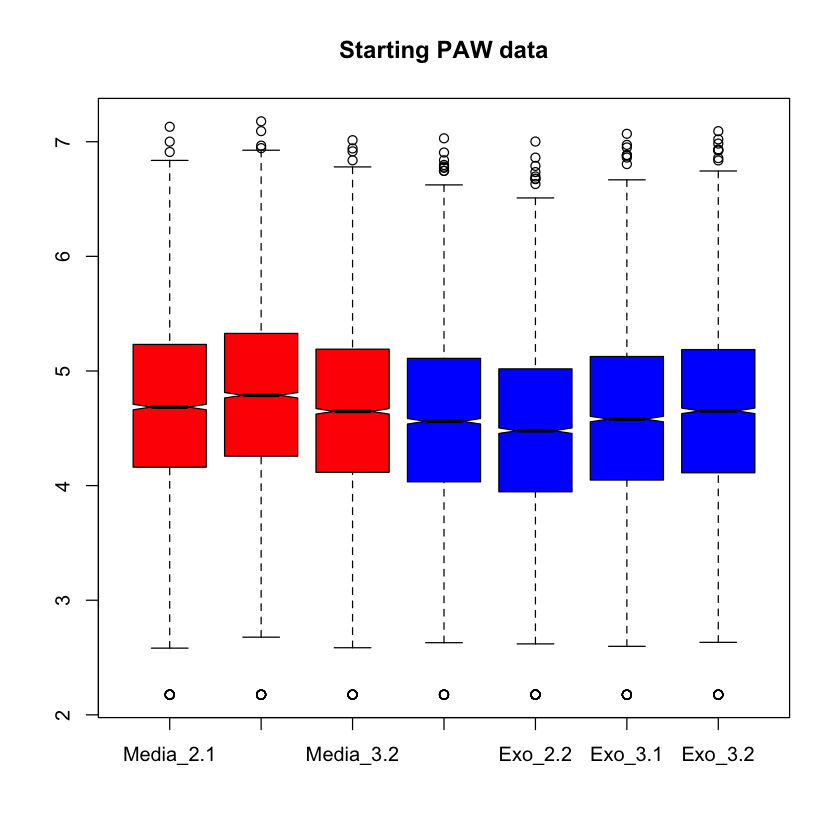

In [4]:
# let's see what the starting data look like
color = c(rep("red", 3), rep("blue", 4))
boxplot(log10(paw_tmt), col = color, notch = TRUE, main = "Starting PAW data")

## Do we need to do some data normalization?

The boxplots are not very well horizontally aligned. A global scaling seems in order. Each channel is supposed to be the same total amount of protein digest that was labeled. We would, therefore, expect the total sum of reporter ion intensities to be the same in each channel.

We can make a function that takes the column sums, computes the average sum, and scales each column so that its new sum will be the average.

SL Factors:
 Media_2.1 -> 0.883421
 Media_2.2 -> 0.714969
 Media_3.2 -> 0.990676
 Exo_2.1 -> 1.206812
 Exo_2.2 -> 1.474747
 Exo_3.1 -> 1.094219
 Exo_3.2 -> 0.962132


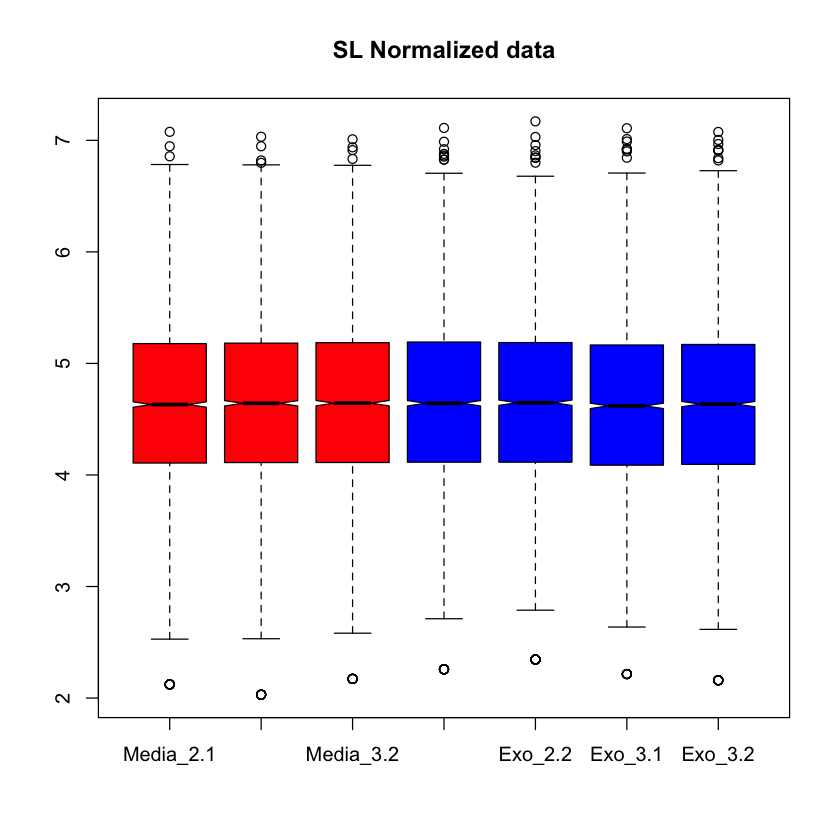

In [5]:
SL_Norm <- function(df, color = NULL, plot = TRUE) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    
    # compute scaling factors to make colsums match the average sum
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(df_sl), col = color, notch = TRUE, main = "SL Normalized data")
    }
    df_sl
}

# SL norm the tmt data
paw_tmt_sl <- SL_Norm(paw_tmt, color)

### We can check the column sums before and after normalization

The normalization brought the boxplots into horizontal alignment. We can double check the computations by seeing if the column sums are equal after normalization.

In [6]:
print("Before:")
format(round(colSums(paw_tmt), digits = 0), big.mark = ",")
print("After:")
format(round(colSums(paw_tmt_sl), digits = 0), big.mark = ",")

[1] "Before:"


Media_2.1       Media_2.2       Media_3.2         Exo_2.1         Exo_2.2 
"1,027,236,544" "1,269,260,855" "  916,023,072" "  751,966,489" "  615,347,770" 
        Exo_3.1         Exo_3.2 
"  829,342,908" "  943,200,022"

[1] "After:"


Media_2.1     Media_2.2     Media_3.2       Exo_2.1       Exo_2.2 
"907,482,523" "907,482,523" "907,482,523" "907,482,523" "907,482,523" 
      Exo_3.1       Exo_3.2 
"907,482,523" "907,482,523"

## Data was loaded, TMT data extracted, and normalization checked

The basic starting steps in any analysis are to make sure the data was read in correctly. Proteomics summary files usually have lots of information in addition to the quantitative data. Some work to extract the correct quantitative columns will be needed (this is often called the data wrangling part of an analysis). Filtering of rows that should be excluded from the statistical testing is also necessary. Those include common contaminants, any decoy proteins, and proteins that might have too much missing data to be reliable.

The extracted data may need some further formatting depending on the downstream statistical testing requirements. Here, we are saving the protein accession information as a vector and the actual TMT reporter ions as a 2D table of numbers.

Some exploratory statistics on the starting data are always a good idea. R has many functions to do far more than we have done here. We did some very basic checks to see what the data looked like before and after one simple normalization method. The basic features of the data look okay, so we will move on to the statistical testing.

---

# A brief history of quantitative proteomics

In the dark ages before proteomics, mass spectrometers were made of stone (sector magnets and chemical ionization) and the t-test was developed to test beer (an essential ingredient of proteomics from the very beginning). Then came the not-so-golden ratio age (Penning ion traps, Q-TOFs, ICAT, and SILAC) where quantitative proteomics became synonymous with ratios and fold-changes. Battle lines were drawn between complicated standard formats with lengthy command line processing pipelines and the enduring allure of mysterious "black box" commercial products.

Ironically, progress on the instrument side seems to have accelerated while advances on the processing side seems to be in an ice age glacial state. We have seen an increase in the number of standard formats and their complexity. They seemed to have found the sweet spot of being quite hard for both humans **and** computers to read. We now have shiny "open source" black boxes to compete with more faded commercial black boxes. Statistical testing has evolved from one ratio (and no need for statistics) to boatloads of ratios as multiplexing capacity has increased. This leads to a literal "log" jam that might involve beer consumption because it always ends up with a t-test.

Can we actually do quantitative proteomics without going down this ancient, overgrown path to failure? The answer is **yes**. Genomics had a head start on proteomics and has been doing the larger sample number, complicated experimental designs that biological studies require for many years. Modern instruments and methods are producing quantitative proteomics datasets that are much more similar to genomics data than they were in the past. If we do a little research (are we not scientists?) into genomic tools and data formats, we can learn how to prepare proteomics data to leverage these more mature statistical packages and stop trying to invent square wheels and making sacrifices to the Volcano plot Gods.

Joking aside, proteomics needs to recognize the similarity between proteomics and genomics data and abandon outdated thinking that was never all that useful. Computers and data science methods have changed just as much as new instruments like the timsTOF have changed compared to a sector magnet mass specs.

---

## Differential expression (DE) testing

This is not the place for a review of hypothesis testing. It is, however, a good place to get the gist of statistical testing in this context and define some concepts for the rest of the notebook. There are **many** types of proteomics experiments, and they fit into many analysis pigeon holes. A common scenario is testing if a protein is expressed at the same or different levels in a background of many other proteins.

Complex protein mixtures from two or more biological conditions (such as control and treatment, or normal and disease) are compared by making measurements of relative abundances. There are some hidden constraints in these experimental designs. The total amount of protein is usually fixed at the same value across all samples (an individual biological replicate) and there is a dynamic range within the proteomes. High abundance proteins are constrained by the total protein amount and do not have the same freedom for abundance differences that proteins that are smaller fractions of the total have. Higher abundance proteins must, by experimental design, have moderated differences in means and reduced variances. Lower abundance proteins have more freedom and will not really appear to be constrained.

The constrained nature of these experimental designs (both genomics and proteomics) also has implications in normalization algorithms. An increased expression in abundant proteins will "push" all other proteins down (their abundance total has to remain the same). Grand total normalization like we use above can be too simplistic. The Bioconductor (**Ref-6**) differential expression testing package edgeR (**Ref-7**) includes a trimmed mean of M values (TMM) normalization step (**Ref-8**) designed for these types of samples.

> **6.** Gentleman, R.C., Carey, V.J., Bates, D.M., Bolstad, B., Dettling, M., Dudoit, S., Ellis, B., Gautier, L., Ge, Y., Gentry, J. and Hornik, K., 2004. Bioconductor: open software development for computational biology and bioinformatics. Genome biology, 5(10), p.R80.

> **7.** Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> **8.** Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

---

#### The next parts of the notebook will demonstrate using edgeR to do DE testing:

- proteomics data can be very similar to genomics data
- robust genomics statistical packages can be used
- statistical models and test results can be checked with visualizations

---

## Load data into edgeR data structures

Bioconductor uses its own data classes. The main data table is organized by each gene or protein in a separate row, and each biological sample in a separate column. Genes/proteins can have rich annotations and the samples can have metadata. Think of this like a table of information about the rows and a table of information about the columns. These are linked tables. If you change the data rows, you have to update the row table, etc.

EdgeR has extensive [documentation](https://www.bioconductor.org/packages/devel/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) and you can read more about its data classes in the user's guide. We need to get the reporter ion intensities into a DGEList object. In addition to the data table, we can add the protein accessions as row labels, and the group membership (plain media or exosome dosed) information. We will use variable names similar to what is in the user's guide to make learning more about edgeR easier.

In [7]:
# load data into DGEList object
group <- c(rep("media", 3), rep("exosome", 4))
y <- DGEList(counts = paw_tmt, group = group, genes = accession)
y$samples

,group,lib.size,norm.factors
Media_2.1,media,1027236544,1
Media_2.2,media,1269260855,1
Media_3.2,media,916023072,1
Exo_2.1,exosome,751966489,1
Exo_2.2,exosome,615347770,1
Exo_3.1,exosome,829342908,1
Exo_3.2,exosome,943200022,1


## We loaded the unnormalized TMT data
EdgeR normalization is actually done in two steps. The first, called a library size adjustment, is like the SL normalization we did above. This gets rid of the big differences between samples so that the TMM algorithm has better starting data.

In [8]:
# run the TMM normalization
y <- calcNormFactors(y)

# check what happened to the normalization factors
y$samples

,group,lib.size,norm.factors
Media_2.1,media,1027236544,1.0315782
Media_2.2,media,1269260855,1.0419173
Media_3.2,media,916023072,1.0251194
Exo_2.1,exosome,751966489,0.9914967
Exo_2.2,exosome,615347770,0.9996507
Exo_3.1,exosome,829342908,0.9566440
Exo_3.2,exosome,943200022,0.9571947


## edgeR computes correction factors

EdgeR does not change the counts table. The "samples" list slot does get new norm.factor values. EdgeR uses the normalization factors as offsets in its modeling. We will want to check the TMM step and visualize the data results, so we need to get a table of normalized data values. A more detailed discussion of edgeR normalization can be found [here](https://pwilmart.github.io/TMT_analysis_examples/MAN1353_peptides_proteins.html). We will use a function that returns a data frame of normalized data from a DGEList object.

Overall Factors (lib.size+TMM):
 Media_2.1 -> 0.856378
 Media_2.2 -> 0.686205
 Media_3.2 -> 0.966401
 Exo_2.1 -> 1.217162
 Exo_2.2 -> 1.475263
 Exo_3.1 -> 1.143810
 Exo_3.2 -> 1.005158


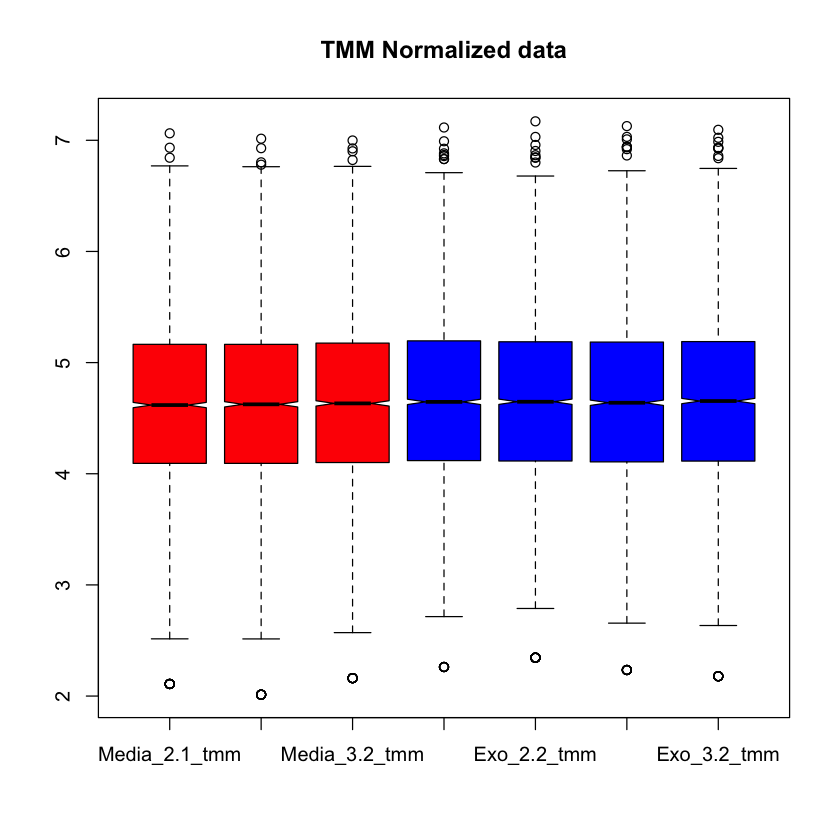

In [9]:
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# get the normalized data values
paw_tmt_tmm <- apply_tmm_factors(y, color)

### Examine returned data and compute column totals

In [10]:
head(paw_tmt_tmm)

print("After TMM:")
format(round(colSums(paw_tmt_tmm), digits = 0), big.mark = ",")

Media_2.1_tmm,Media_2.2_tmm,Media_3.2_tmm,Exo_2.1_tmm,Exo_2.2_tmm,Exo_3.1_tmm,Exo_3.2_tmm
3368441.7,3024217.7,3549656,4096808,4244800,4675091,4926046
4947045.8,5003598.5,5760711,7375533,7340496,8322252,8495868
869172.6,863222.4,1048879,1168980,1206257,1889414,2008571
5884076.1,5785474.7,6652110,6774659,6308658,8687534,8611277
4780244.7,4820828.4,5825930,7205432,6958487,8758912,8428680
4953541.4,4853469.8,5052309,6779562,7025872,7300663,6898731


[1] "After TMM:"


Media_2.1_tmm Media_2.2_tmm Media_3.2_tmm   Exo_2.1_tmm   Exo_2.2_tmm 
"879,703,110" "870,973,668" "885,245,657" "915,265,344" "907,799,611" 
  Exo_3.1_tmm   Exo_3.2_tmm 
"948,610,508" "948,064,728"

### Column totals are not all the same

The point of TMM is that changes in the abundance of more abundant proteins distort the grand totals. That is the trimmed part of the algorithm. With freedom to change the abundances of the more abundant proteins, the column totals will no longer stay constrained. Even though the column totals are not the same, the boxplots are nicely aligned. 

If we have large adjustment factors, it means we have some compositional differences between samples. That has to be reconciled with what is known about the system under study. Generally, some compositional differences between conditions could make sense. Compositional differences between samples within the same condition could mean contaminating tissue in a dissection, for example. 

It is critical to remember that most normalization methods assume large numbers of proteins with unchanged expression are present in the samples. These methods are for samples in conditions that are mostly similar in their proteomes. When that is not the case, much more care has to go into picking a normalization method.

## CV distributions are a good metric to test normalizations

Now that we have the table of TMM normalized data, we can do a few more QC type visualizations. We should have smaller CV values when normalization has worked well. If we do not get relatively tight CV distributions with nice median CV values, there are two likely reasons. There is significant inherent biological variability between samples (humans), or the sample preparation is too variable (need to optimize more).

In [11]:
# define variables for the columns in each condition
M <- 1:3
E <- 4:7

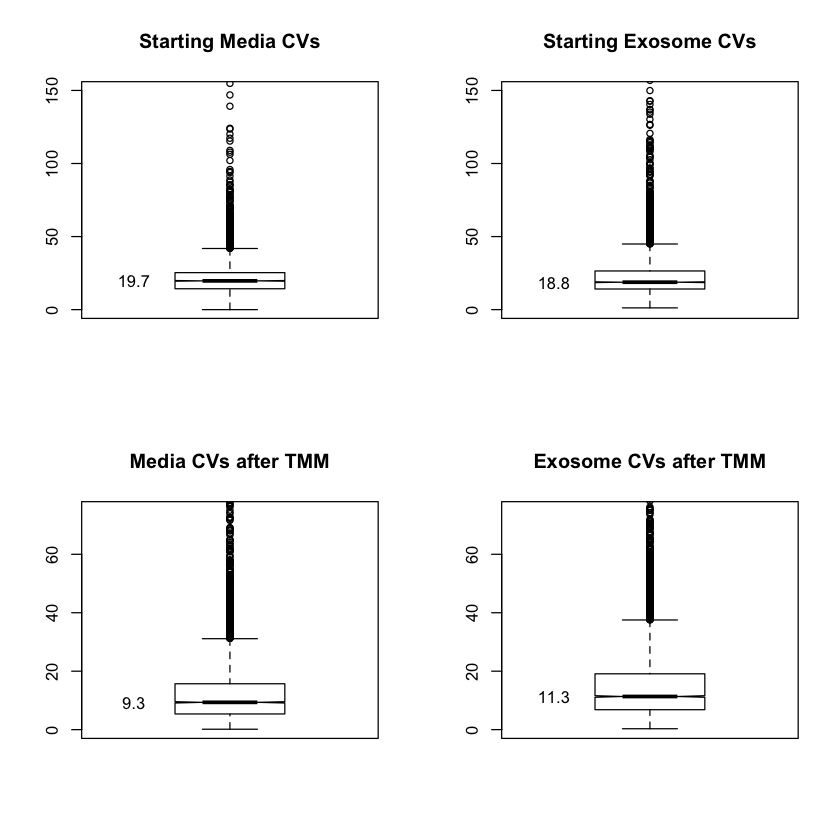

In [12]:
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# compare CV distributions
par(mfrow = c(2, 2))
labeled_boxplot(paw_tmt[M], ylim = 150, title = "Starting Media CVs")
labeled_boxplot(paw_tmt[E], ylim = 150, title = "Starting Exosome CVs")
labeled_boxplot(paw_tmt_tmm[M], ylim = 75, title = "Media CVs after TMM")
labeled_boxplot(paw_tmt_tmm[E], ylim = 75, title = "Exosome CVs after TMM")
par(mfrow = c(1, 1))

## Check how the samples cluster

This is a two-condition comparison. One of the 4 media only samples did not label. The cultures were done in two batches ("2.x" and "3.x" in the labels). We expect to see the media only samples cluster together and be separated from a cluster of the exosome dosed samples. 

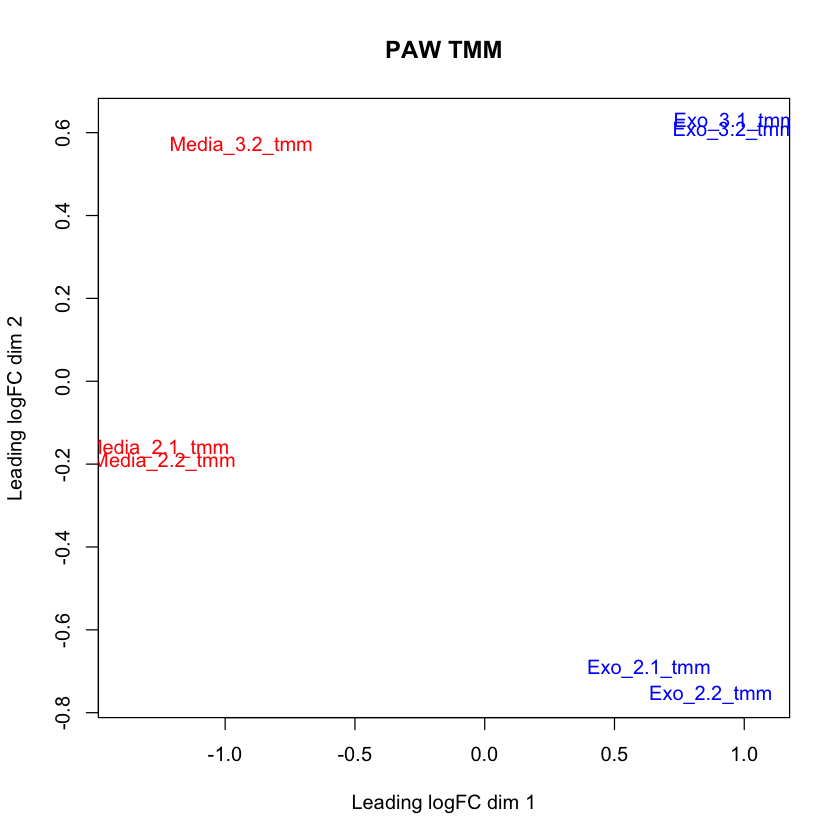

In [13]:
# see how things cluster after we have normalized data
plotMDS(log2(paw_tmt_tmm), col = c(rep("red", 3), rep("blue", 4)), main = "PAW TMM")

### Conditions separate left-to-right in first dimension

Media only clearly separates from exosome dosed in the leading dimension. These MDS plots are like principal component analysis. The x-axis is the major dimension of differences between samples, the y-axis is the second most important dimension of difference. The samples are separating left-to-right by condition. We probably also have a culture prep batch effect between batch 2 and 3. We should have more samples in each condition before attempting things like batch corrections, so we will focus on the differences between media and exosome conditions. 

## Compare samples to each other with scatter plots

Multi-panel scatter plot grids are another exploratory data analysis technique that is well supported in R. We can see how similar biological replicates are to each other within the median only condition or in the exosome dosed condition. We can also see if the samples between conditions seem different. We would expect to see larger differences (more scatter) between groups that within groups. 

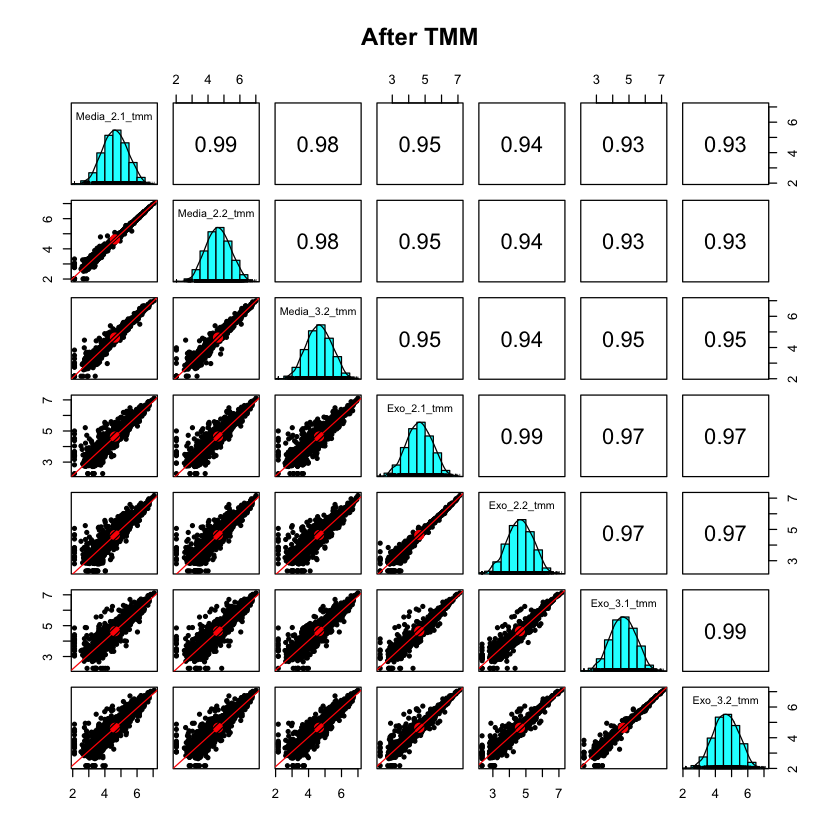

In [14]:
# scatter plots within groups and betwen groups
pairs.panels(log10(paw_tmt_tmm), lm = TRUE, main = "After TMM")

### Within condition samples are a bit tighter than between conditions

Correlation coefficients are larger within conditions than between conditions, but the differences are not large. Correlation coefficients are not a great metric. Media only samples are a little more similar between batch 2 and 3 than are the exosome dosed samples. Samples within the same condition and within the same batch are pretty similar to each other. 

# Back to the statistical testing... 

The typical analysis goes something like this:

- load the data into DGEList object
- run TMM and normalize the data
- check for experimental issues with cluster plot
- estimate dispersion trends for moderated statistics
- plot the Biological Coefficient of Variation (BCV)
- do the pair-wise tests and get p-values, FDRs
- check the p-value distribution
- visualize DE results
  - MA plots
  - scatter plots
  - volcano plot
- gather normalized data and test results into table
- write out the final results table

We have already done the first 3 steps.

Design matrix not provided. Switch to the classic mode.


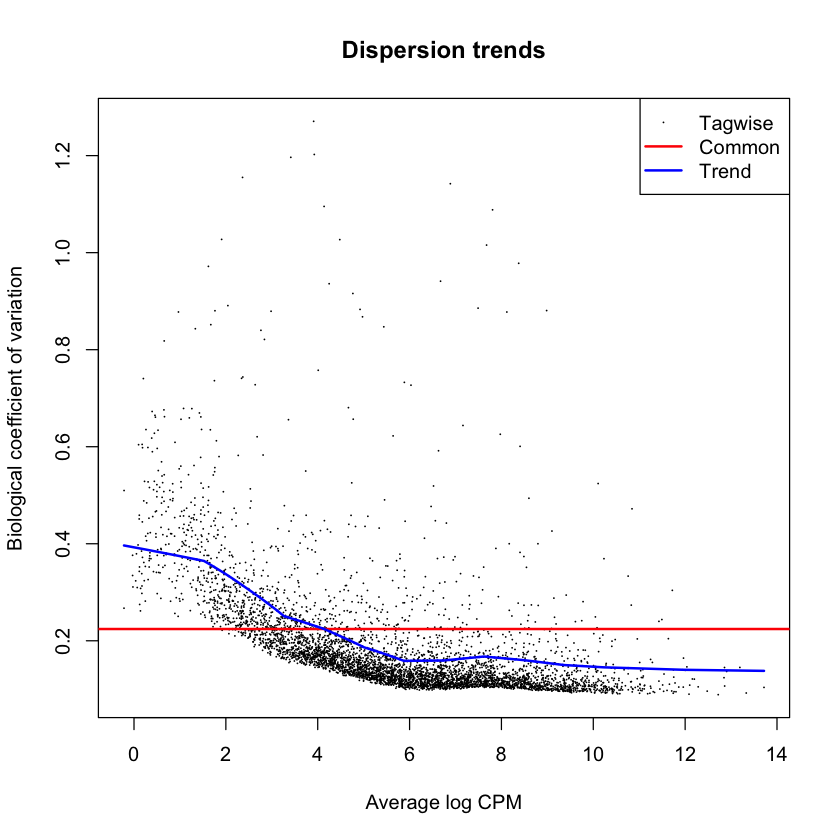

In [15]:
# we need to get dispersion estimates
y <- estimateDisp(y)
plotBCV(y, main = "Dispersion trends")

## Dispersion depends on the protein intensity

There are commonly abundance-dependent dispersion effects in many measurement methods. Higher abundance signals have better signal-to-noise (or are the result of more averaging), so they can appear more precise than lower abundance signals. We see that the blue line increases as the protein intensity decreases. The statistical testing will use trended variances (estimated from multiple proteins) **as a function of** protein intensity, which spans several orders of magnitude. 

If we had summarized the data using ratios, we would have collapsed the range on protein values into a concentrated blob centered at 1:1 ratios. We would lose all ability to have trended variance estimates. The trended variance is how the test statistics are moderated and is why limma and edgeR outperform t-tests in typical study designs where replicate numbers can be small. I do not know how many replicates in each condition are needed before the trended variance stops improving results (10, 20, 50?). I think most proteomics studies are still considerably short of replicate numbers where the t-test will work well. Avoiding ratios is **very important** in getting the best results.

### edgeR exact test

We will use the exact test in edgeR for this simple two-state comparison. EdgeR has general linear model extensions that allow for more complicated experimental designs. They are a bit more work to set up and run. We will avoid that here, but the [user's guide](https://www.bioconductor.org/packages/devel/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) has many examples.

If you read up on edgeR or know a bit about statistics, you may wonder why we are using statistical testing built on a negative binomial distribution for counting experiments. The short answer is because it seems to work fine. The short longer story is that the variance is modeled by two terms: one for Poisson numbers and an over-dispersion term. As counts get larger (a few hundred or so), the Poisson term becomes small and the variance is handled by the over-dispersion term. The values of reporter ion peak heights, particularly when summed into protein totals, are large enough numbers. One could argue that limma would be a better choice. However, limma is a little more complicated to set up and run than edgeR. 

Notebooks are a great framework for trying different analysis steps. In the [previous version](https://pwilmart.github.io/TMT_analysis_examples/KUR1502_MQ_PAW.html) of this data set analysis, edgeR testing was compared to a two-sample t-test. Running different tests in R is not hard, what is hard is comparing different analysis methods and trying to define a metric to measure performance.  

In [16]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))

    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("media", "exosome"))

# make the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
med_exo <- collect_results(paw_tmt_tmm, tt, M, "med", E, "exo")

### Run test and reformat results

The `exactTest` function does the modeling for the specified pair. More than one pair can be present in DGEList objects to improve the dispersion estimates. The `topTags` function does the multiple testing corrections and returns more concise summaries of the testing results. The `collect_results` function combines some of the normalized data and test results into a sufficient results data frame.

## Check if testing looks okay

It is important to see if the modeling looks reasonable. Our general assumptions are that we have a large fraction of the proteins that are not differentially expressed. Those will have a uniform (flat) p-value distribution from 0.0 to 1.0. We also expect (hopefully) some true differential expression candidates. Those should have very small p-values and have a sharper distribution at low p-values. 

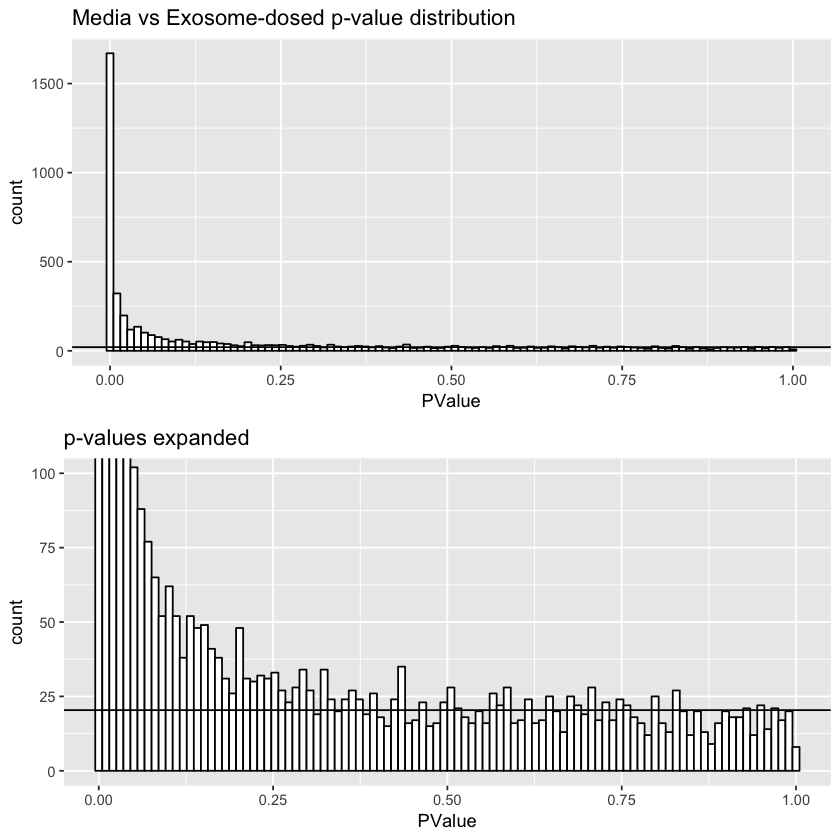

In [17]:
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + 
        ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# check the p-value distrubution
pvalue_plots(med_exo, 100, "Media vs Exosome-dosed")

We have the two distributions of p-values, so the testing seems reasonable. We can also see how the up-regulated protein number compares to the down-regulated number. We can use the `topTags` function to see which proteins have the smallest p-values.

In [18]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# see which proteins have the smallest p-values
topTags(et)$table

       exosome-media
Down            1236
NotSig          2487
Up              1253

,genes,logFC,logCPM,PValue,FDR
4640,sp|Q3UHQ6|DOP2_MOUSE,9.500352,5.836843,1.552477e-187,7.725127e-184
3419,sp|P22777|PAI1_MOUSE,3.785082,3.953547,5.236968e-53,1.302958e-49
4939,sp|Q9QXV1|CBX8_MOUSE,7.129619,6.307572,3.877339e-51,6.060352e-48
450,sp|P54987|IRG1_MOUSE,2.509351,10.097597,4.871666e-51,6.060352e-48
4504,sp|Q9JM51|PTGES_MOUSE,2.278748,5.963784,2.837318e-48,2.823699e-45
4148,sp|P04918|SAA3_MOUSE,3.385478,3.633576,9.952807e-48,8.254195e-45
3118,sp|P33766|FPR1_MOUSE,2.829381,5.537600,1.030196e-46,7.323219e-44
530,sp|Q9R0P3|ESTD_MOUSE,1.616199,10.016199,1.798983e-44,1.118967e-41
4404,sp|Q91XA2|GOLM1_MOUSE,4.487636,5.889516,7.891854e-44,4.363319e-41
1252,sp|P35173|CYT3_MOUSE,2.705802,8.965056,1.363845e-42,6.786495e-40


### We can categorize candidates by ranges of adjusted p-values
In many discovery experiments, a Benjamini-Hochberg adjusted p-value (FDR) cutoff of 0.05 (5%) might be pretty strict. We use a 10% cutoff to distinguish DE from non-DE candidates. We define three cuts on the FDR: 10% to 5% are "low" significance, 5% to 1% are medium significance, and less than 1% are more "highly" significant. Cut values can be adjusted depending on the experimental situation.

We can look at expression ratio distributions as a function of candidate category. If variance is not too variable protein-to-protein, then we would expect larger mean differences to be associated with lower FDR values. Faceted plotting in ggplot2 is a nice method for showing such things.

candidate,n
high,1580
med,534
low,375
no,2487


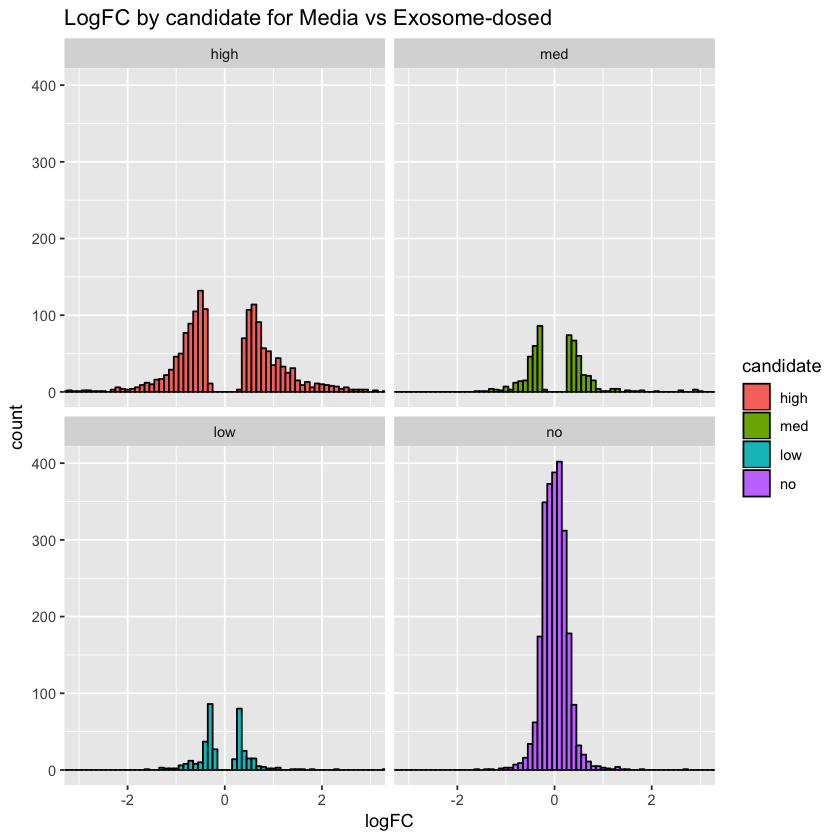

In [19]:
# see how many candidates are in each category
med_exo %>% count(candidate)

log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# can look at log2FC distributions as a check
log2FC_plots(med_exo, 3, "LogFC by candidate for Media vs Exosome-dosed")

## Visualize the edgeR results several ways

- MA plots
- scatter plots
- volcano plot

We need some transformed axes for MA plots and for volcano plots. We will make a function for that and also some functions for the plotting. [MA plots](https://en.wikipedia.org/wiki/MA_plot) first. The dotted lines indicate 2-fold changes.

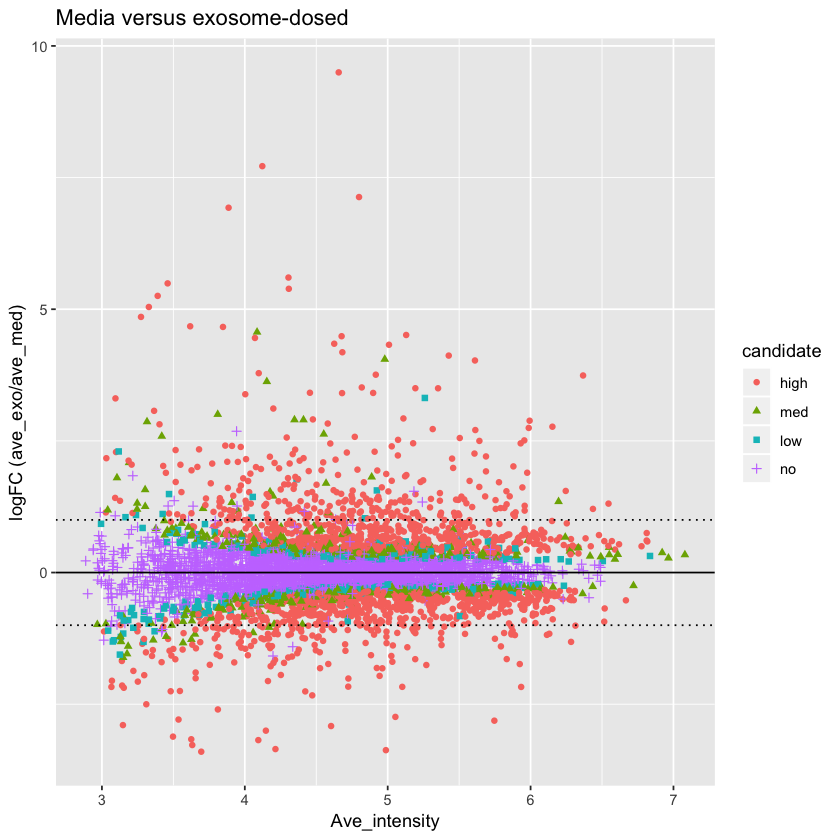

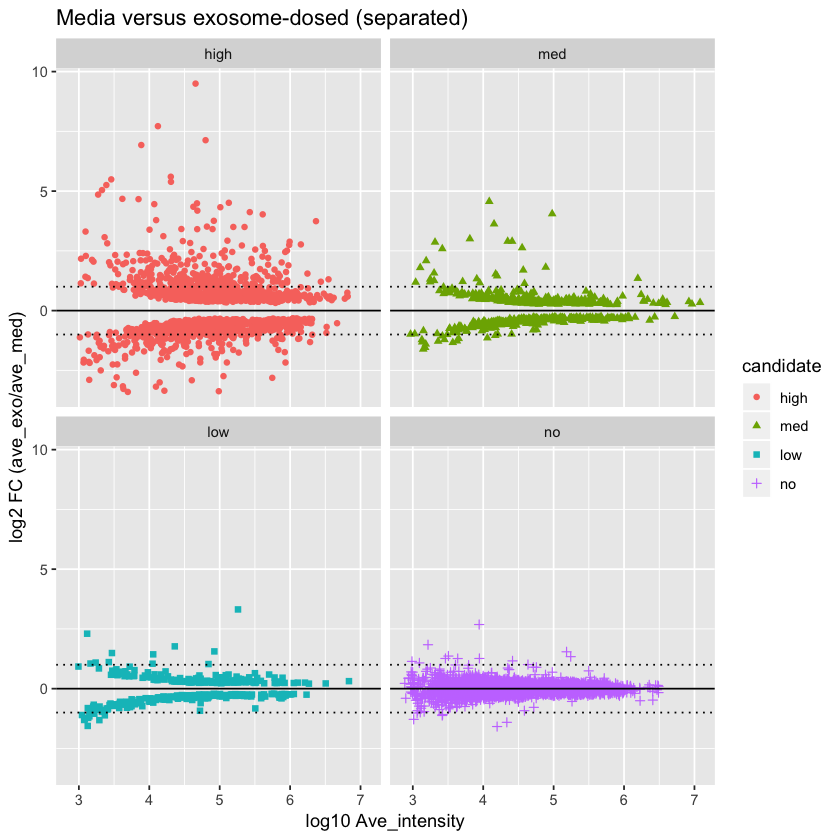

In [20]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    if (make_facet == TRUE) {
        ma_facet <- ggplot(temp, aes(x = A, y = M)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
            scale_x_continuous("log10 Ave_intensity") +
            ma_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)"))
    }

    # make the plots visible
    print(ma)
    if (make_facet == TRUE) {
        print(ma_facet)
    }
}    

# MA plots of DE candidates
MA_plots(med_exo, "ave_med", "ave_exo", "Media versus exosome-dosed")

## Scatter plots

The solid diagonal line is 1:1, the dotted lines are 2-fold changes. The axes are in log scale.

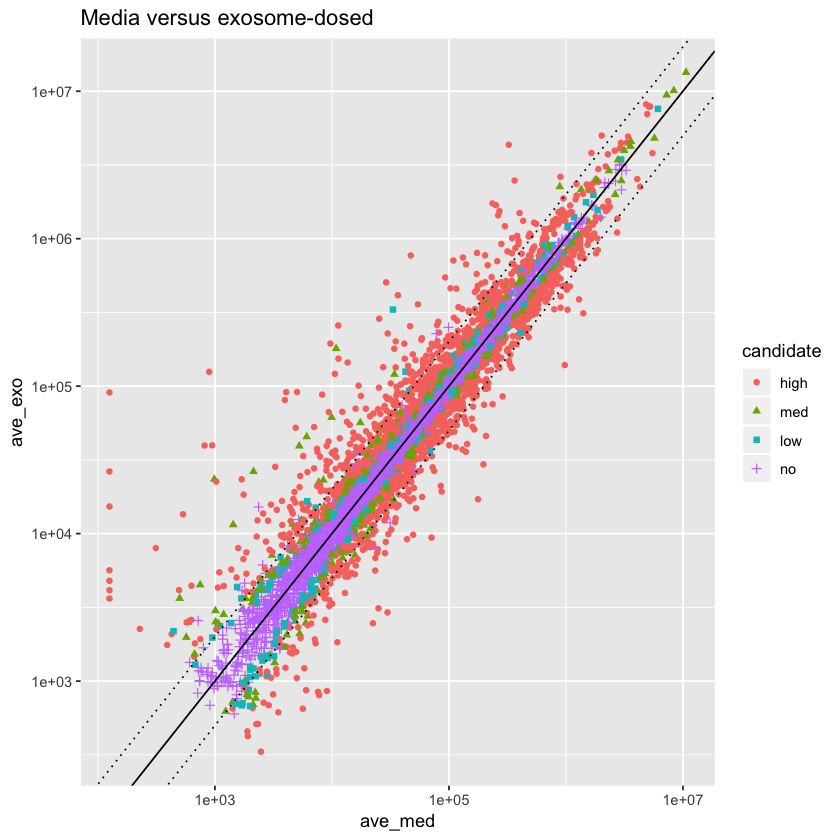

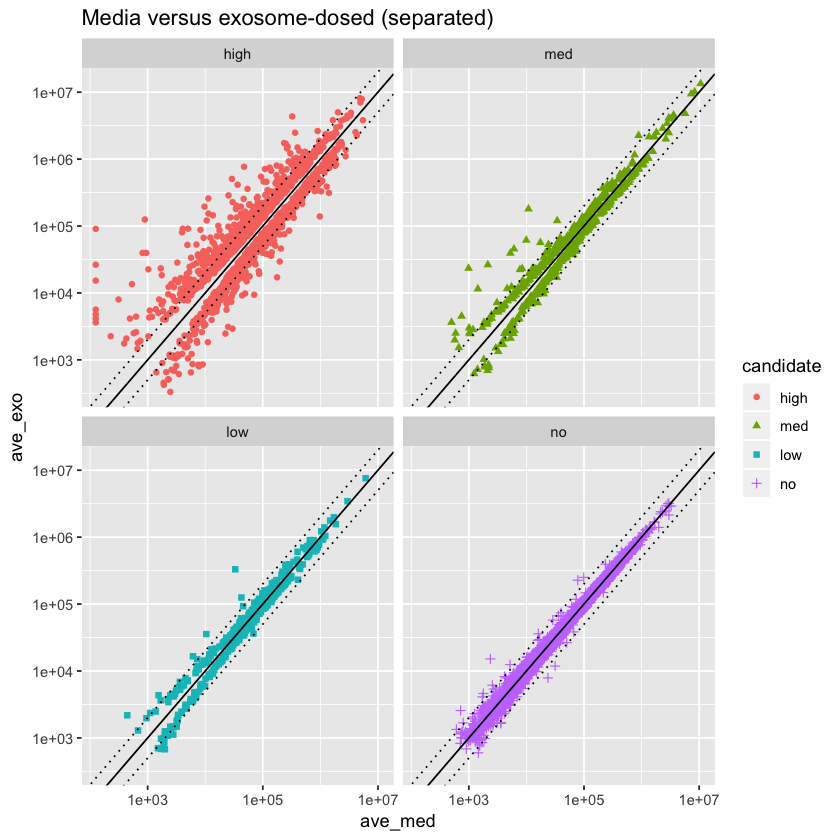

In [21]:
scatter_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    if (make_facet == TRUE) {
        scatter_facet <- ggplot(results, aes_string(x, y)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scatter_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)")) 
    }

    # make the plots visible
    print(scatter)
    if (make_facet == TRUE) {
        print(scatter_facet)
    }
}

scatter_plots(med_exo, "ave_med", "ave_exo", "Media versus exosome-dosed")

## Volcano plot

Volcano plots are another common way to visualize DE candidates.

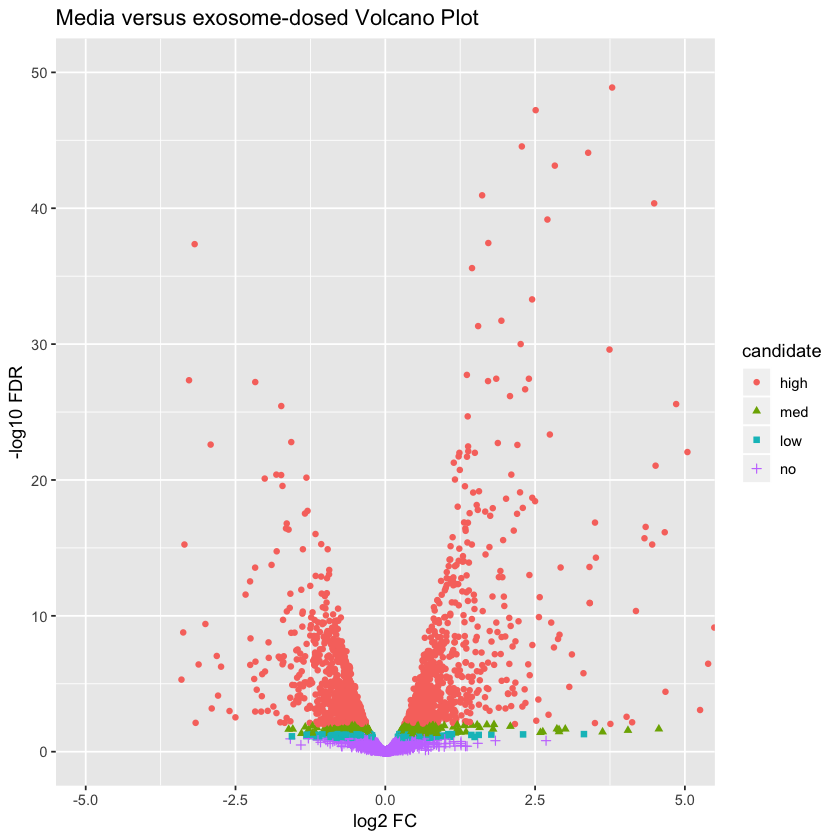

In [22]:
volcano_plot <- function(results, x, y, title, ymax) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # ymax - upper limit for y-axis
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        coord_cartesian(xlim = c(-5, 5), ylim = c(0, ymax)) + 
        ggtitle(str_c(title, " Volcano Plot"))
}

# finally, a volcano plot
volcano_plot(med_exo, "ave_med", "ave_exo", "Media versus exosome-dosed", 50)

## See what the top DE candidates look like 

We can see how the intensities of the individual samples compare for the top 20 up- and down-regulated candidate proteins.

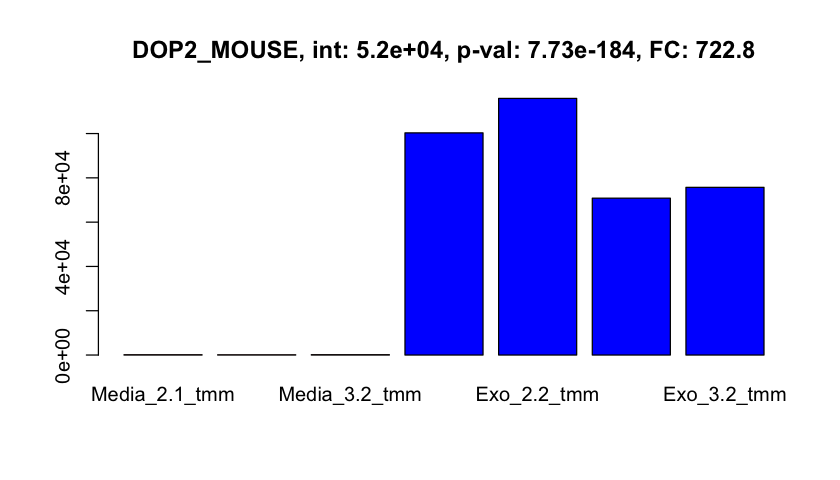

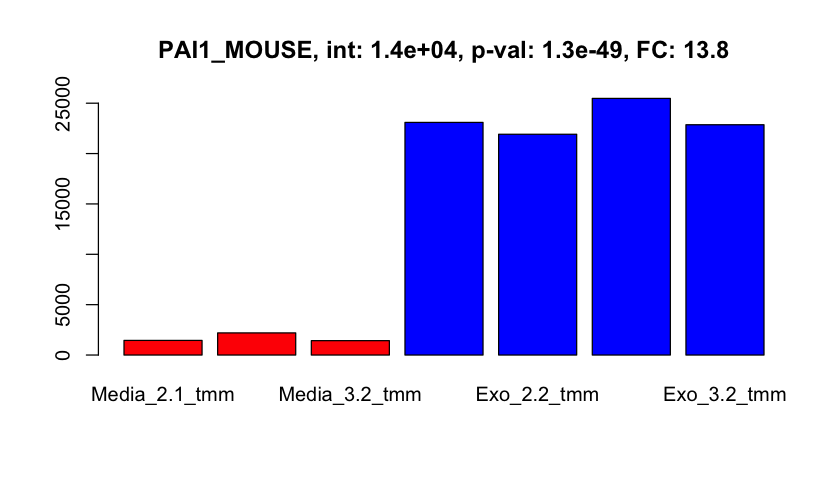

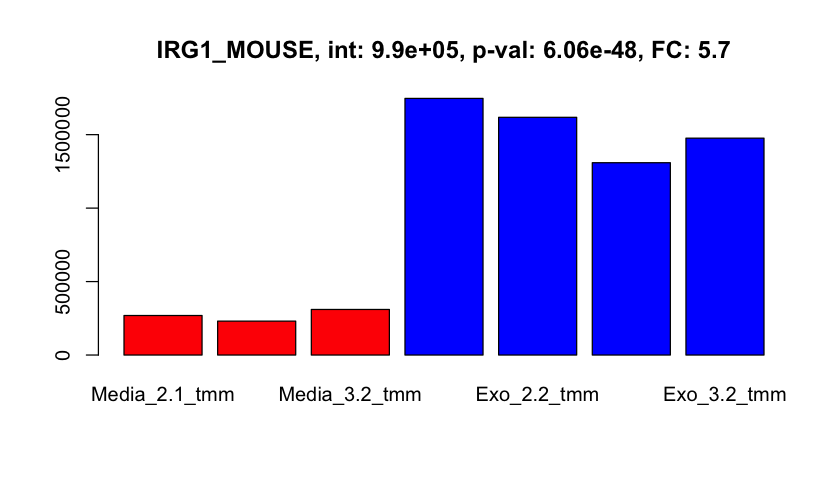

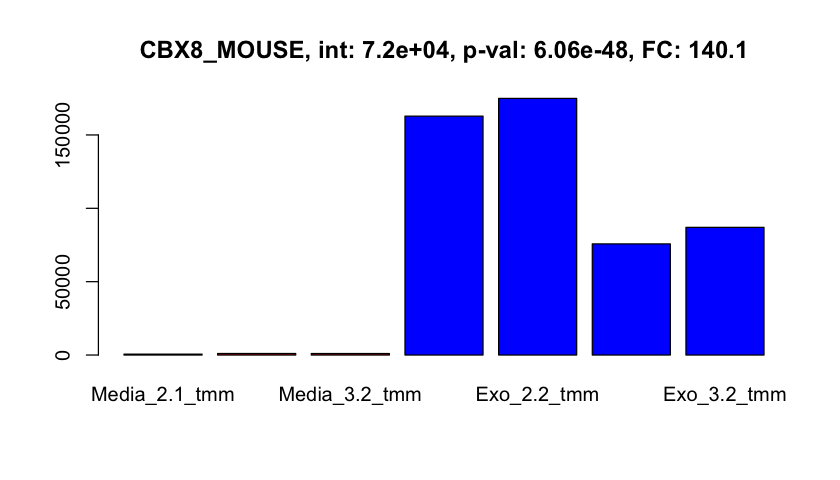

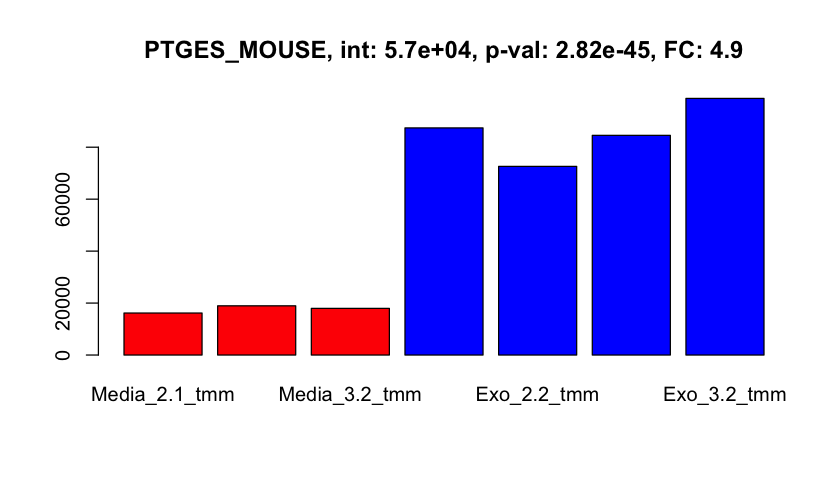

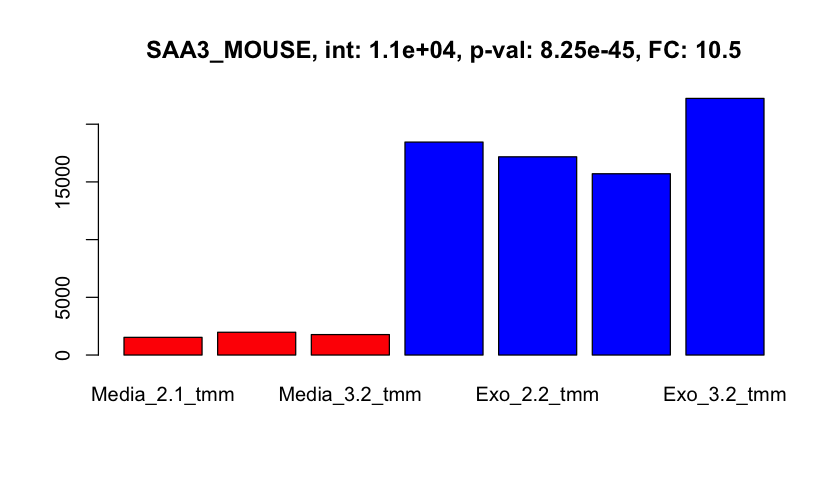

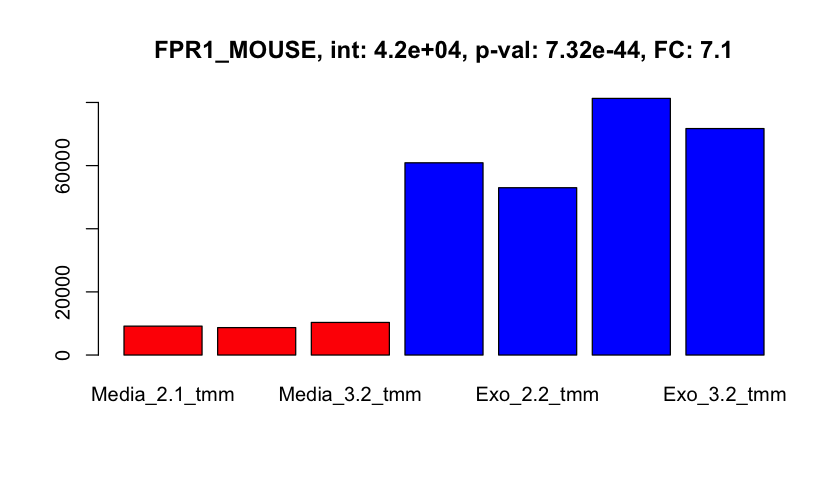

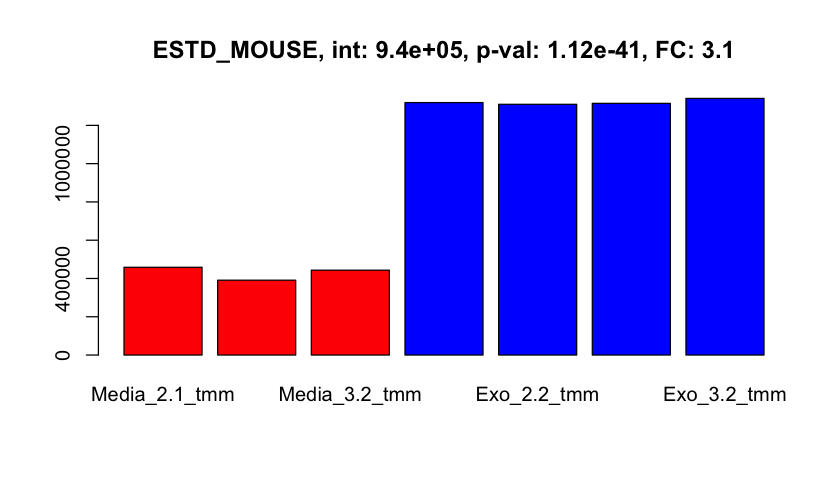

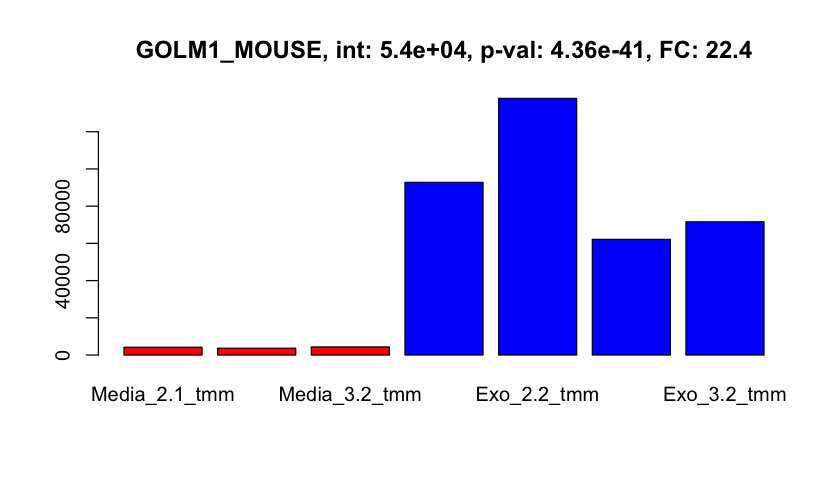

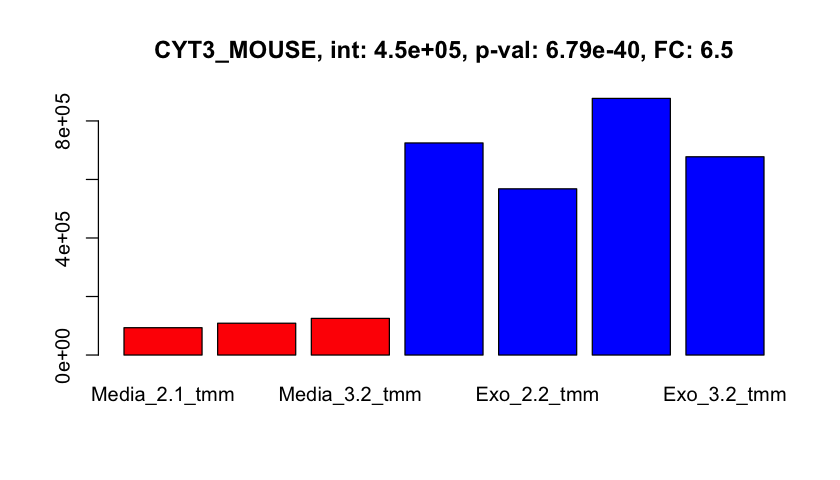

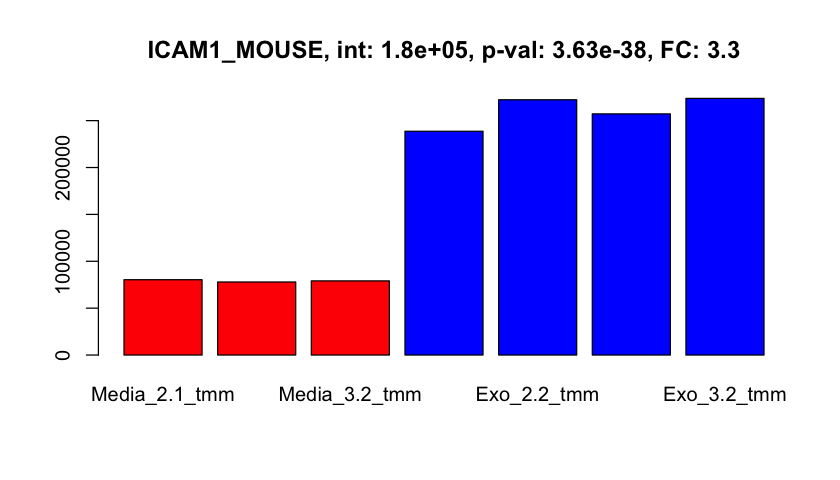

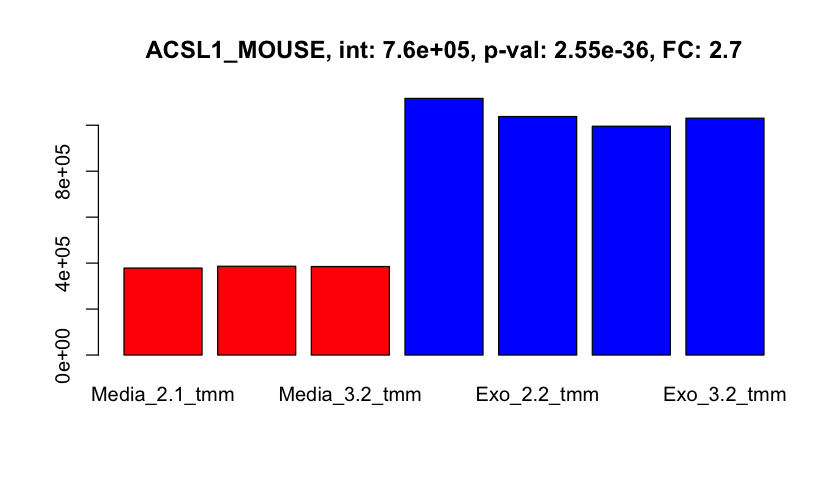

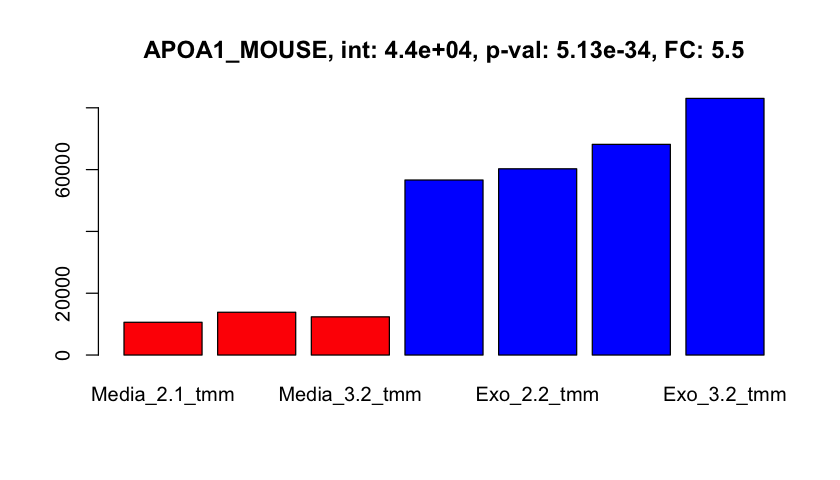

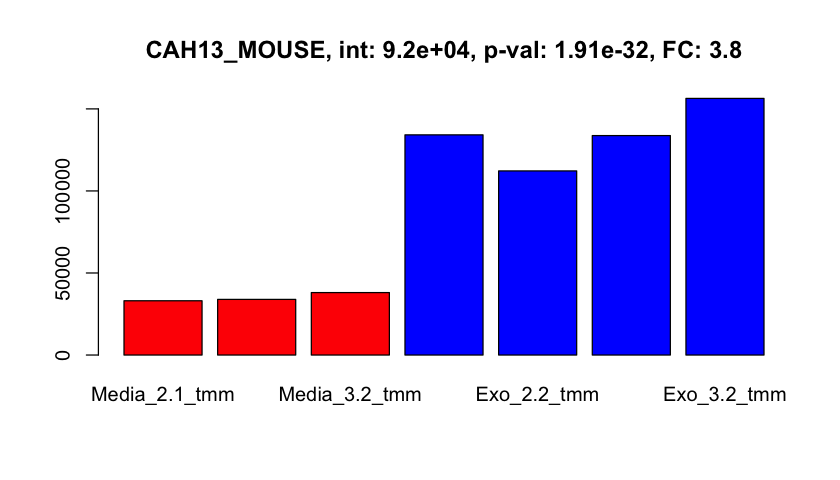

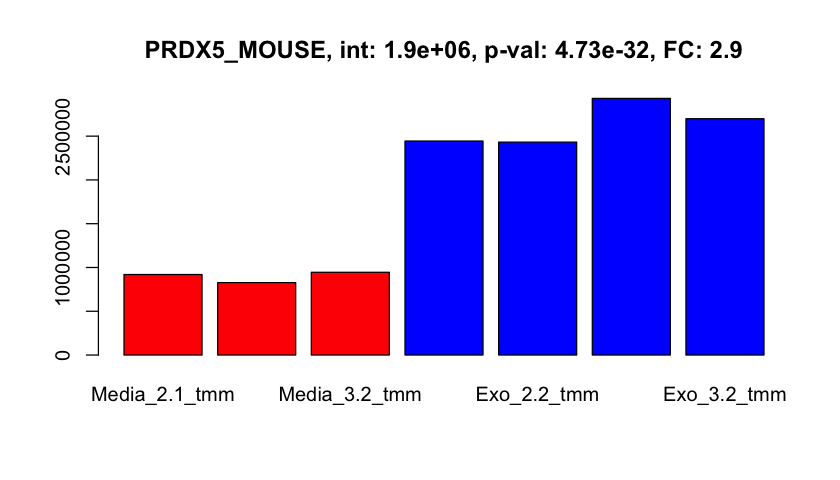

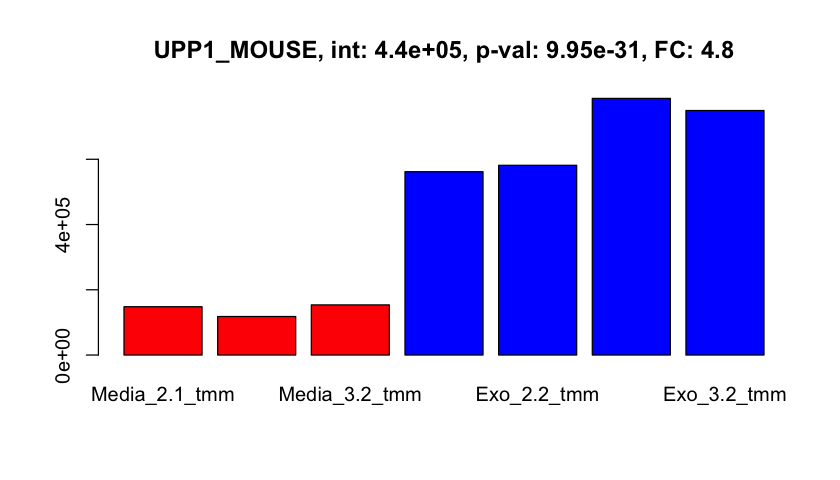

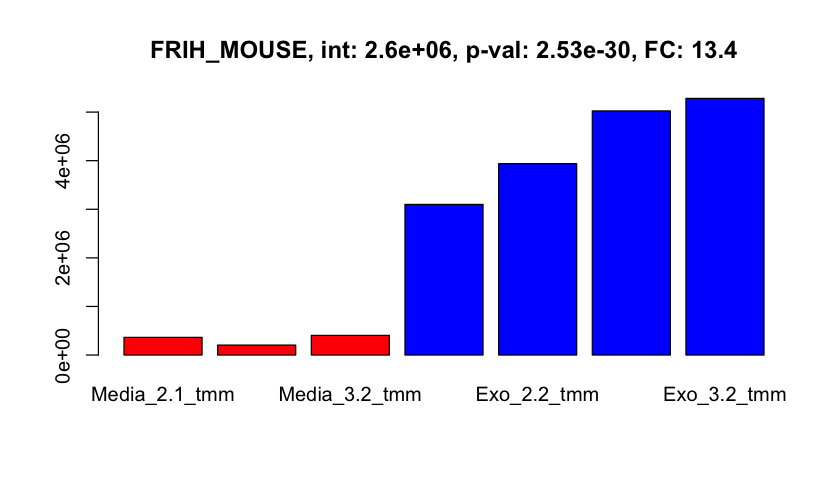

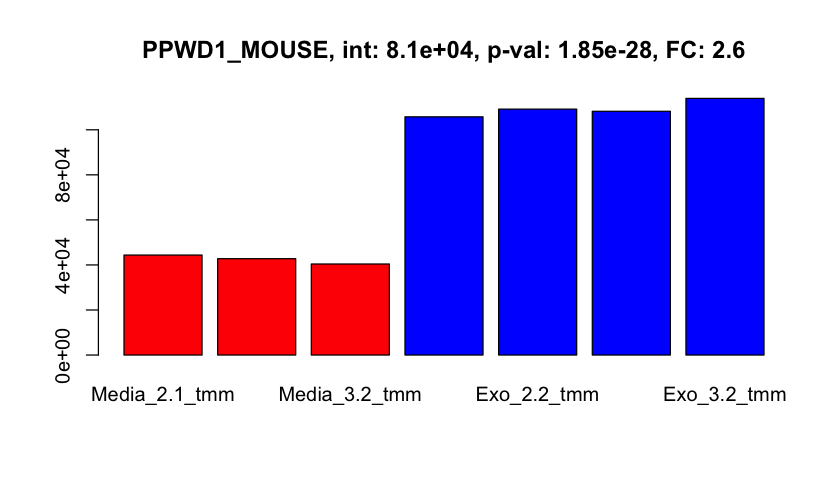

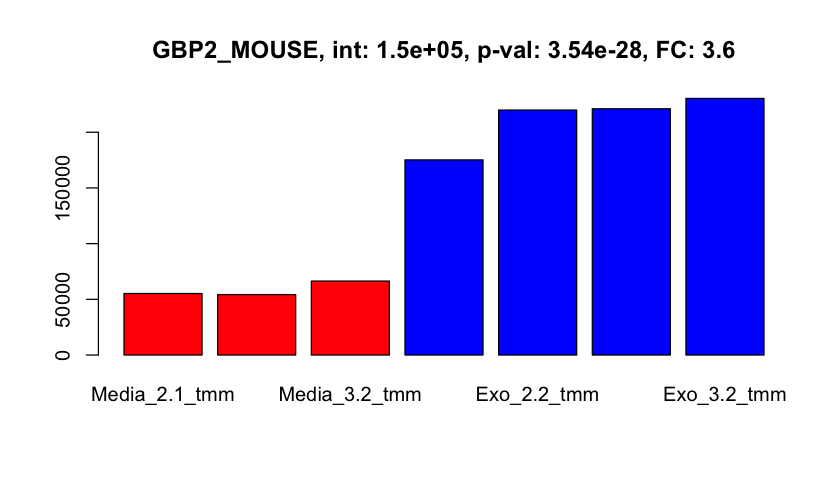

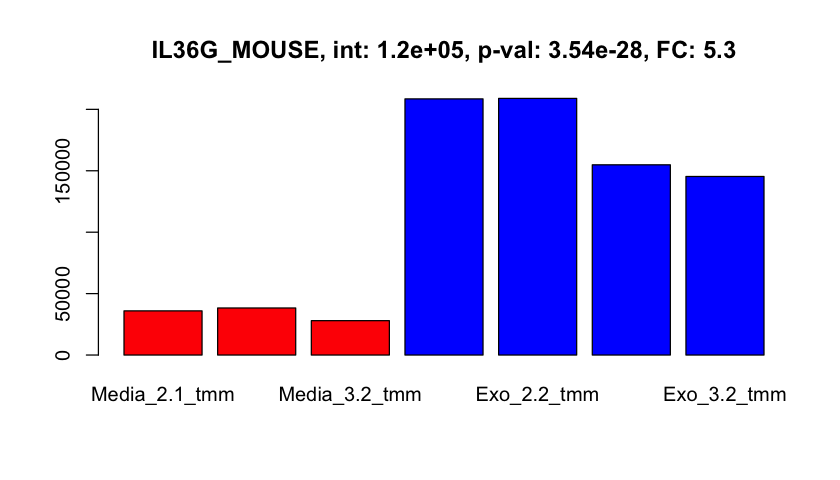

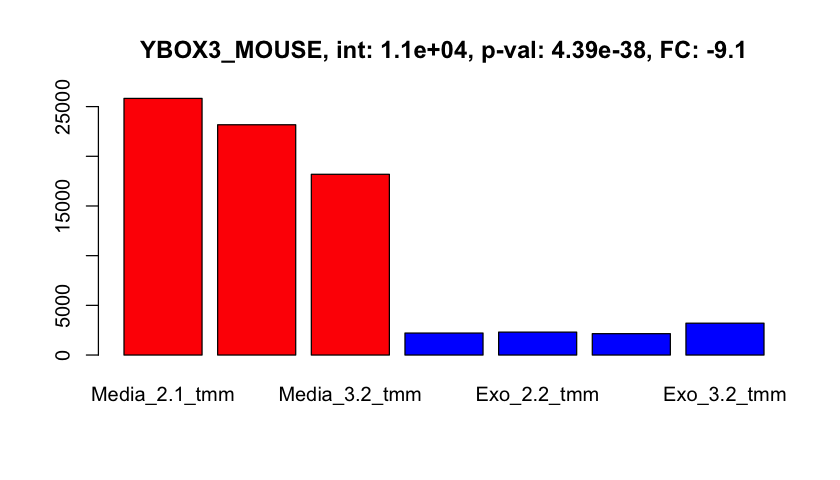

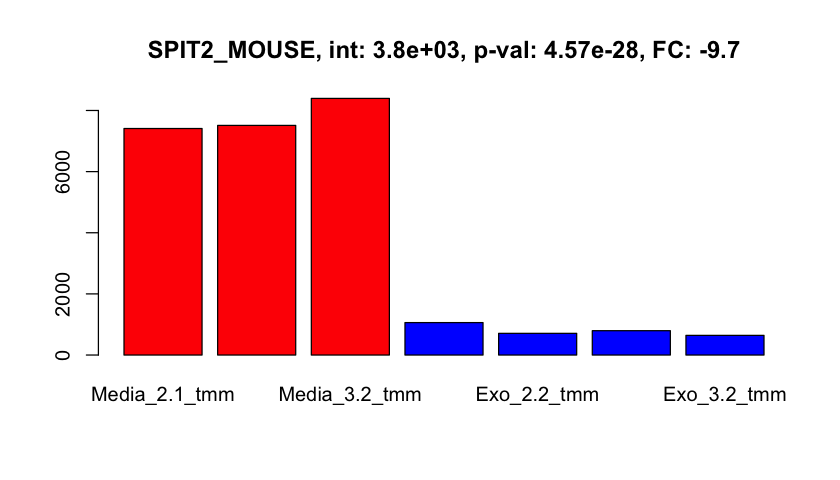

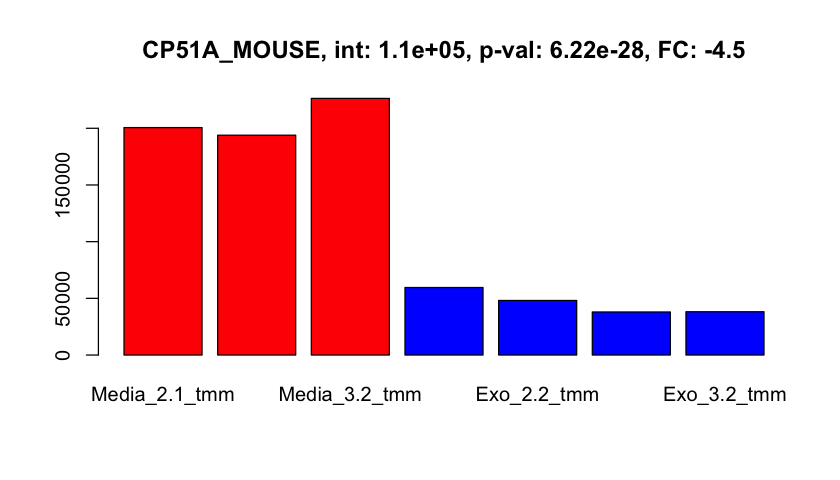

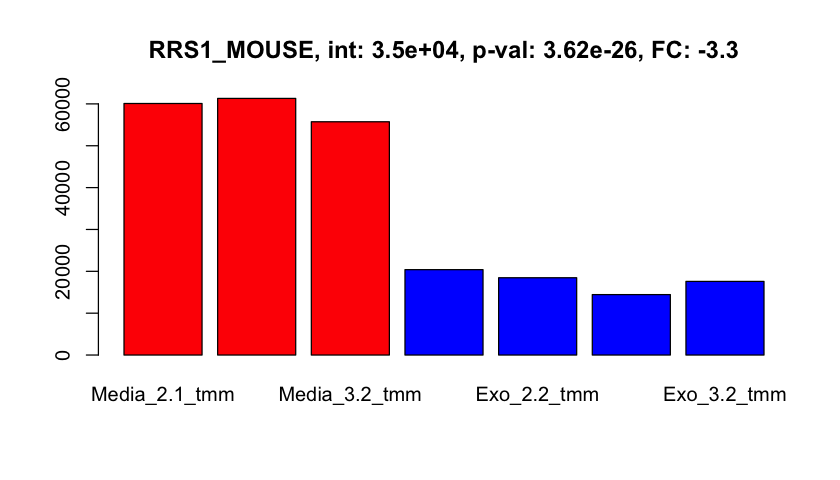

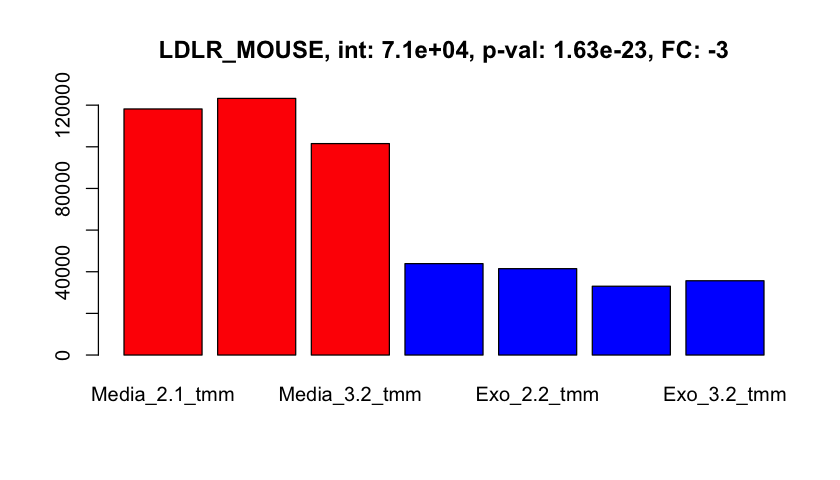

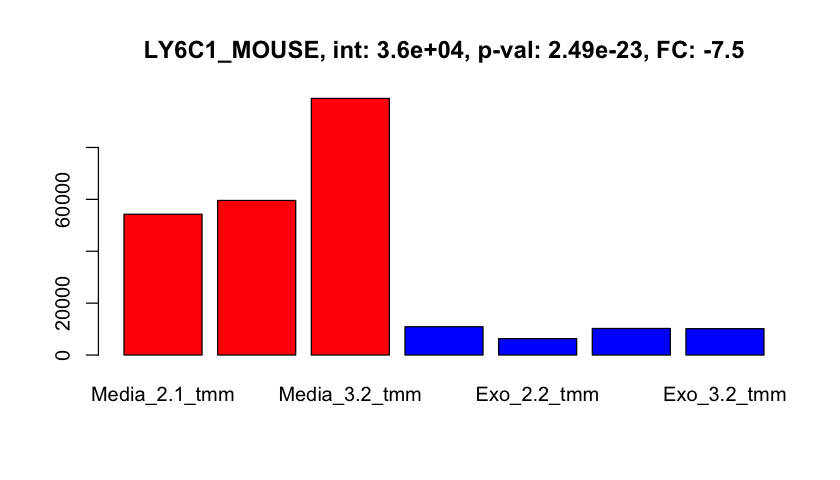

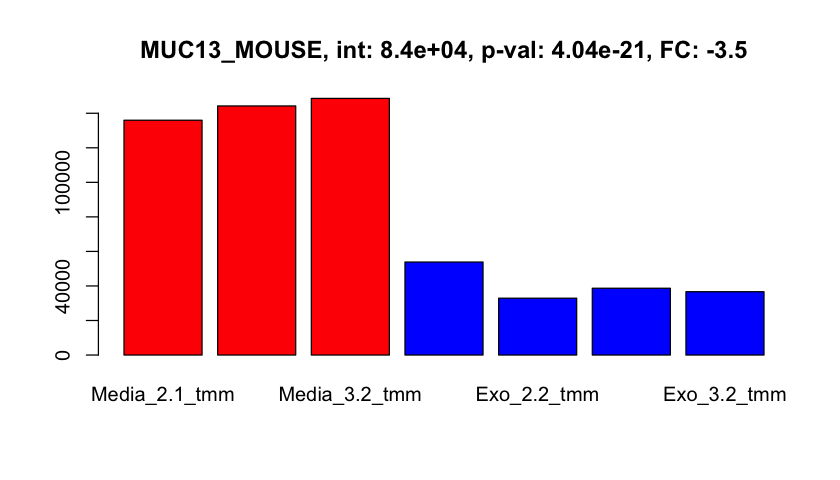

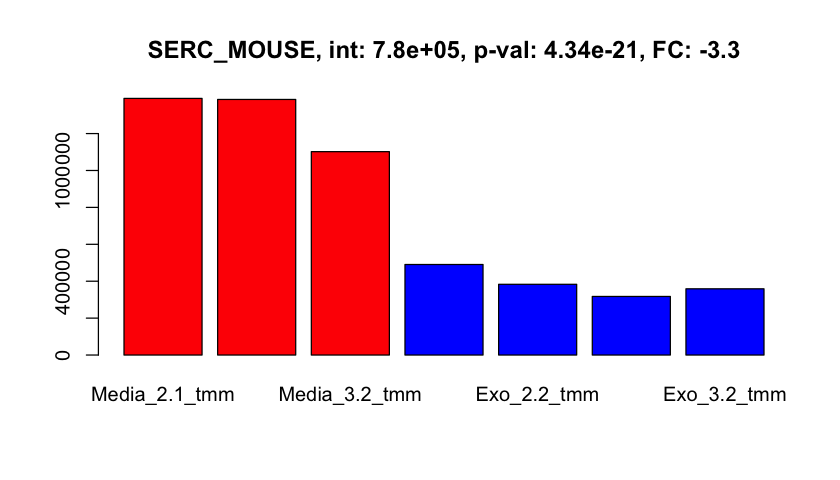

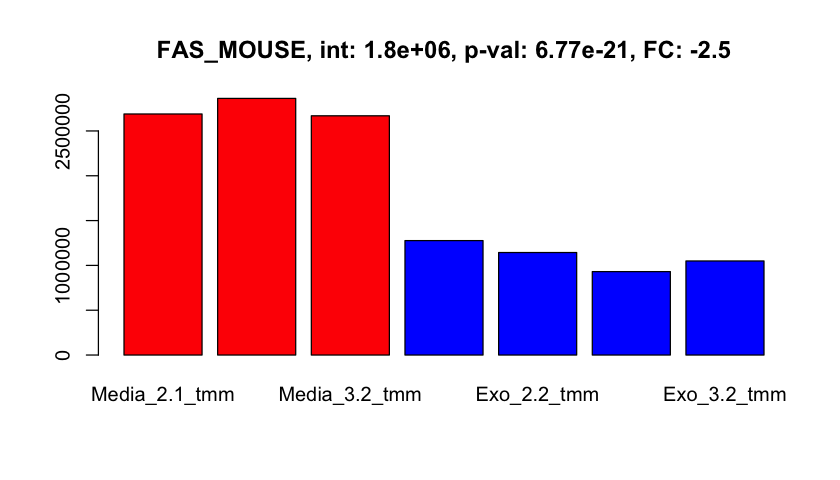

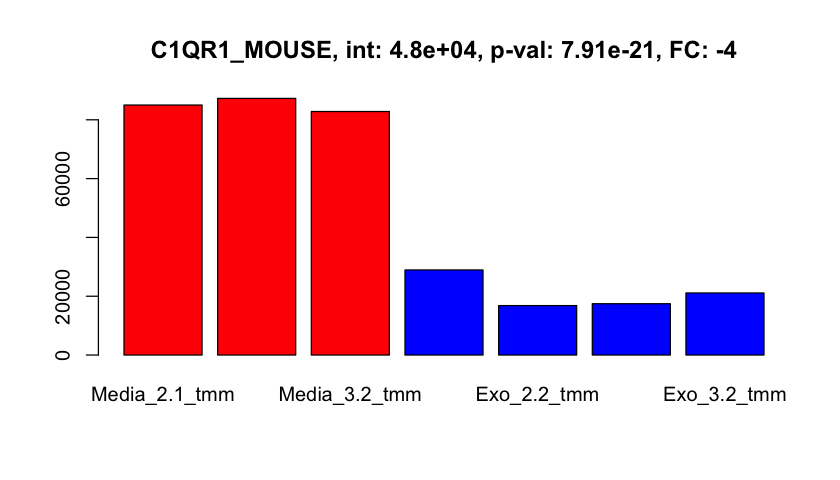

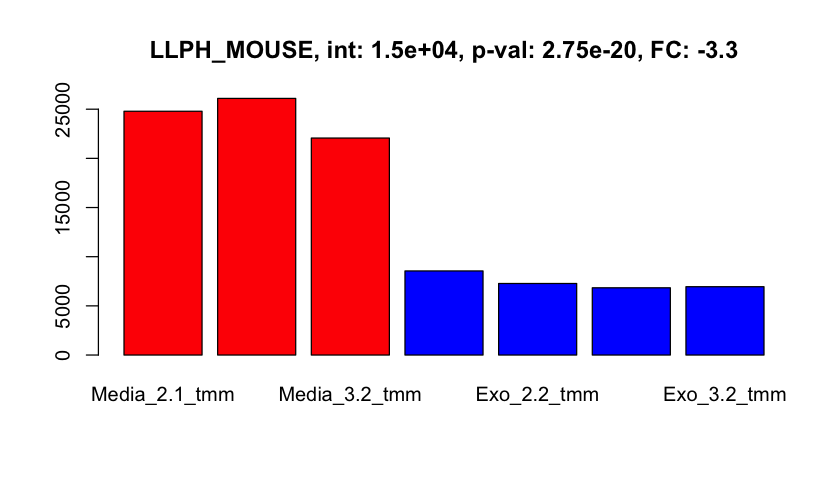

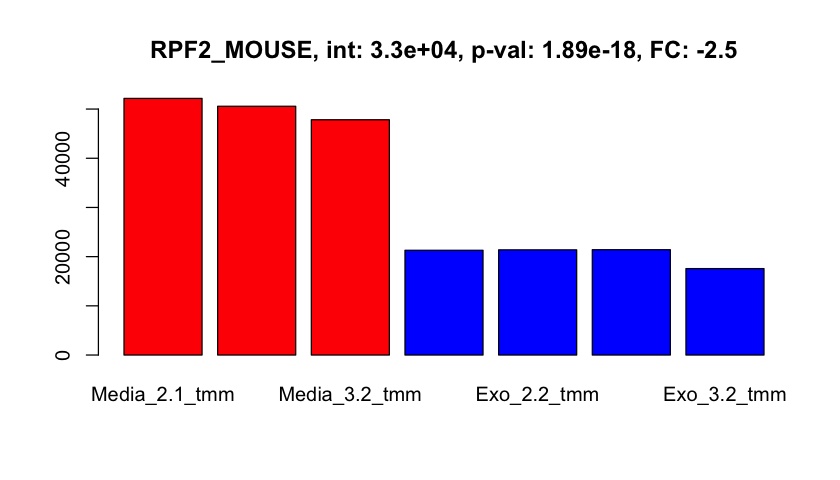

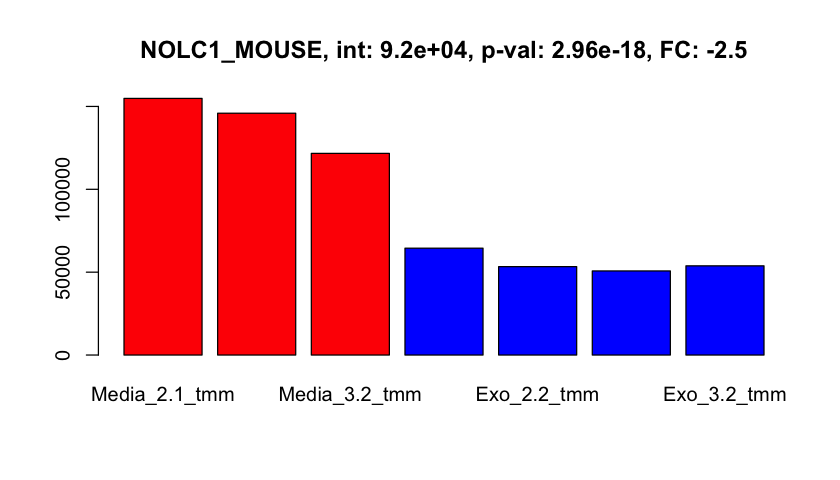

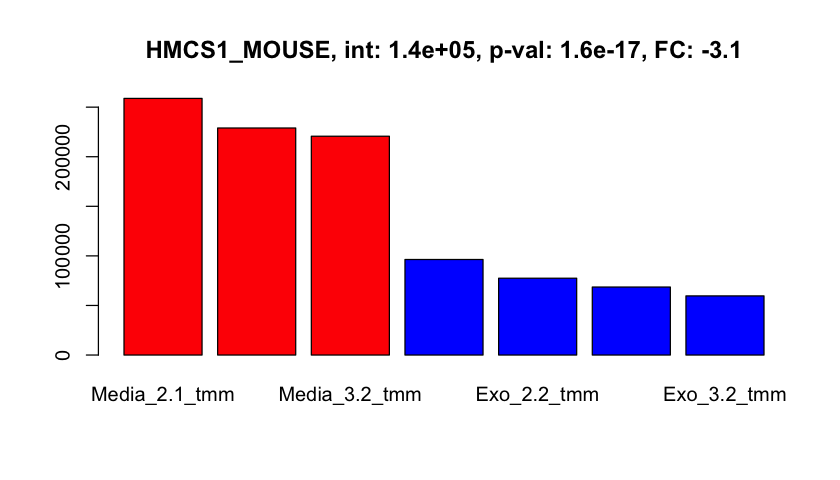

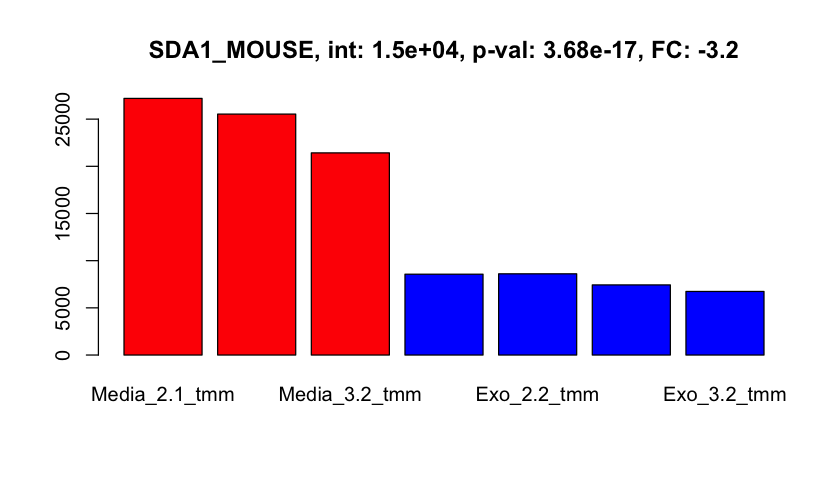

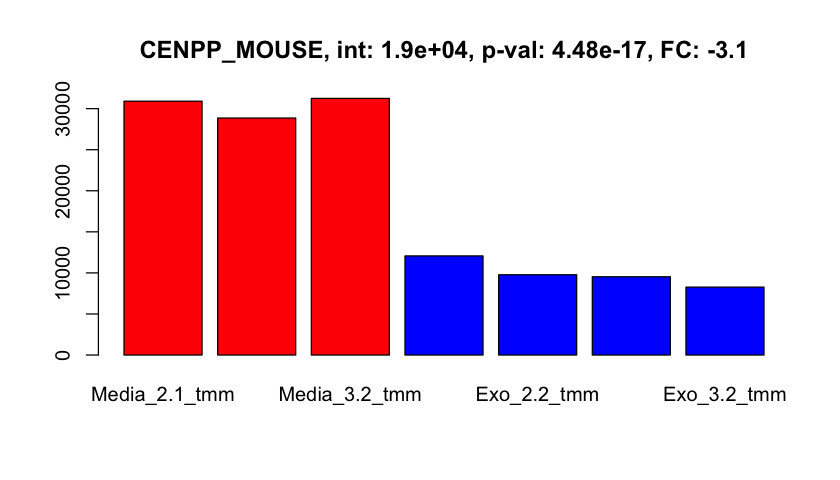

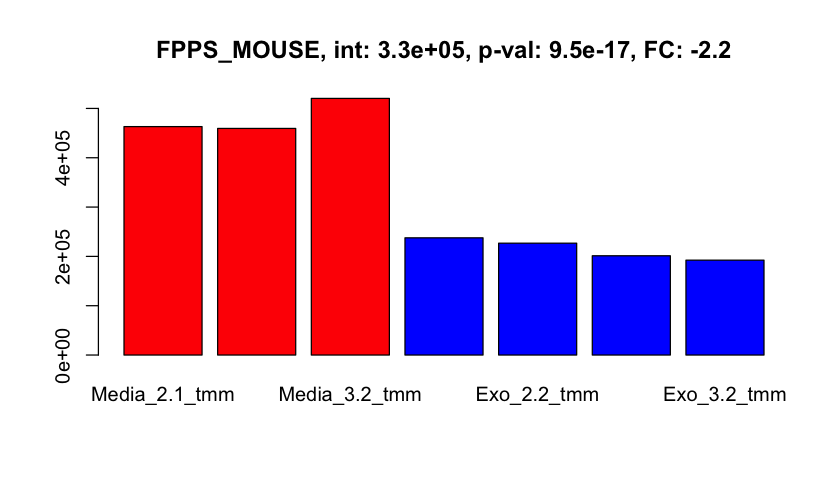

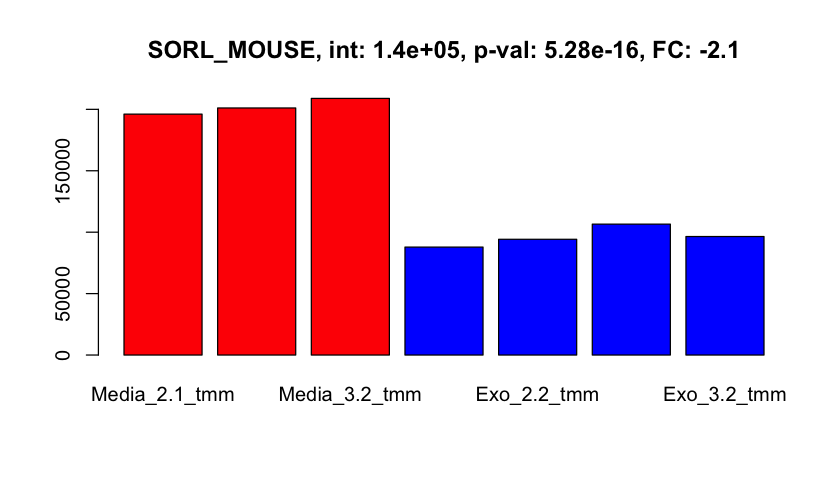

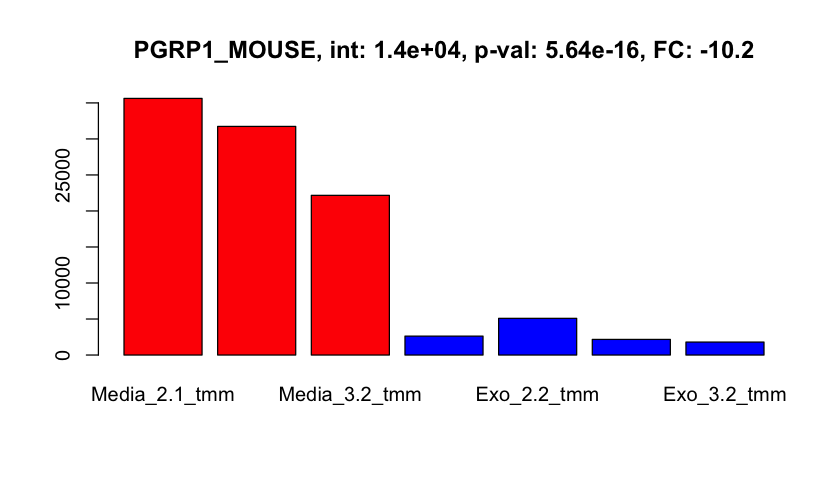

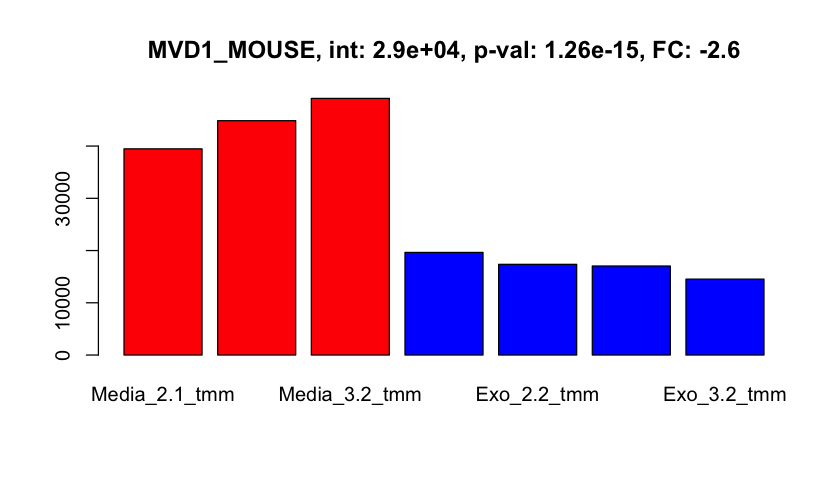

In [23]:
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top up-regulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down-regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

# plot the top 20 up and 20 down proteins
set_plot_dimensions(7, 4)
plot_top_tags(med_exo, 3, 4, 20)
set_plot_dimensions(7, 7)

# Summary
EdgeR normalizations and testing seemed reasonable for this data. 

- non-DE candidate much less than 2-fold (most are closer to 1:1)
- larger fold changes associated with more significant candidates
- wider dispersion at lower intensities is incorporated into edgeR testing
  - need larger fold changes at lower intensities to get the same significance
- proteins with larger fold-changes have much more significant p-values
  - we have a lot of dynamic range in the p-values
- we did not do any isotopic purity corrections
  - true fold-changes could be larger than measured

There were a large number of significant candidates. There are options in edgeR to add a minimum fold-change to the testing. That can be used to reduce the number of candidates. Stricter FDR cutoffs could also be used. Ranking candidates for follow-up study is not trivial. Statistical values like fold-changes and p-values may not be sufficient to determine biologically relevant rankings. Biological information for this system should be an important consideration. 

This would be a much better area to direct informatics students to work on than yet another search engine. There is a very uneven distribution of where talent is directed in these workflows. Label reagents, instrument methods, search engines, and PSM validation have gotten the most attention. Normalizations and statistical models have received some attention. Visualizing results and making biological sense of things are critical steps that have been neglected for too long. This is the critical bottleneck. 

## Getting results out of R
One step towards more meaningful results summaries are getting the main proteomics results and the statistical results combined into a single table. If we are careful with how we bring the data into R and how we take it back out, we can keep tables in order so merging results are easier. There are several strategies that can work well. If the data coming into R and the data coming out of R are not easy to align correctly, then edit the notebooks to make it work right. More data prep can occur before importing into R, for example. We kept the accessions column as we worked with the data. We can be really robust and use merge functions to weave together starting tables with final results tables. 

We should always end notebooks with information about what packages and versions were used in the analysis.

In [24]:
# save the testing results
write.table(med_exo, file = "KUR1502_results.txt", sep = "\t",
            row.names = FALSE, na = " ")

# log the session
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] edgeR_3.24.3    limma_3.38.3    scales_1.0.0    gridExtra_2.3  
 [5] psych_1.8.12    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1  
 [9] purrr_0.3.2     readr_1.3.1     tidyr_0.8.3     tibble_2.1.1   
[13] ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     locfit_1.5-9.1   tidyselect_0.2.5 repr_0.19.2     
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.